In [22]:
import pixeltable as pxt

table = pxt.get_table("poc.data")
# table.show()

/home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/ingestion/.venv/lib/python3.12/site-packages/pixeltable/catalog/table_version.py:449: PixeltableWarning: The computed column 'video_caption' in table 'data' is no longer valid.
The UDF 'core.functions.caption_video' cannot be located, because
the symbol 'core.functions.caption_video' is no longer a UDF. (Was the `@pxt.udf` decorator removed?)
You can continue to query existing data from this column, but evaluating it on new data will raise an error.
  _ = col.value_expr
/home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/ingestion/.venv/lib/python3.12/site-packages/pixeltable/catalog/table_version.py:449: PixeltableWarning: The computed column 'fulltext' in table 'data' is no longer valid.
The UDF 'core.functions.compose_semantics' cannot be located, because
the symbol 'core.functions.compose_semantics' is no longer a UDF. (Was the `@pxt.udf` decorator removed?)
You can continue to q

In [24]:
from pixeltable.iterators.video import FrameIterator

print(table.list_views())
frames = pxt.get_table("poc.frames")
print(frames.columns)

['poc.sentences', 'poc.frames']
['pos', 'frame_idx', 'pos_msec', 'pos_frame', 'frame', 'video', 'audio', 'transcription', 'metadata', 'video_caption', 'fulltext']


pos_msec,frame
0.,
1000.,

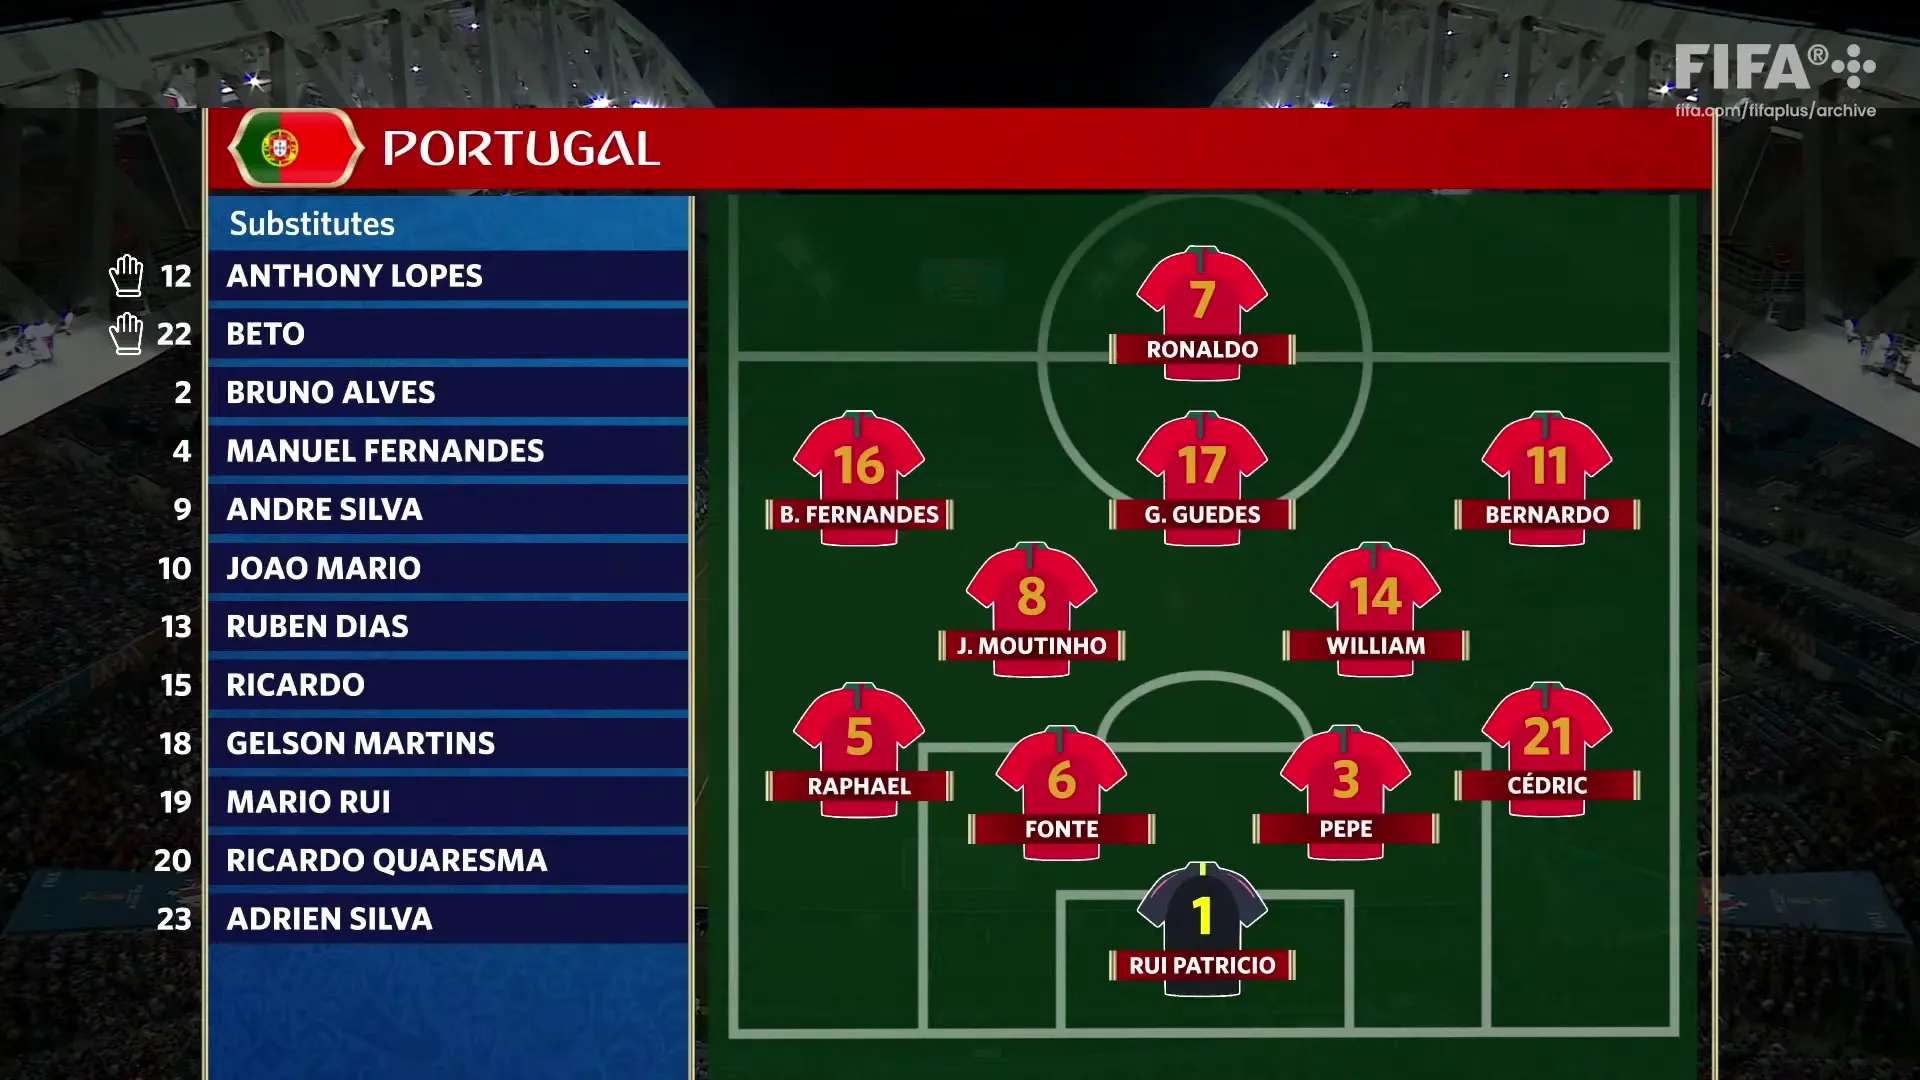
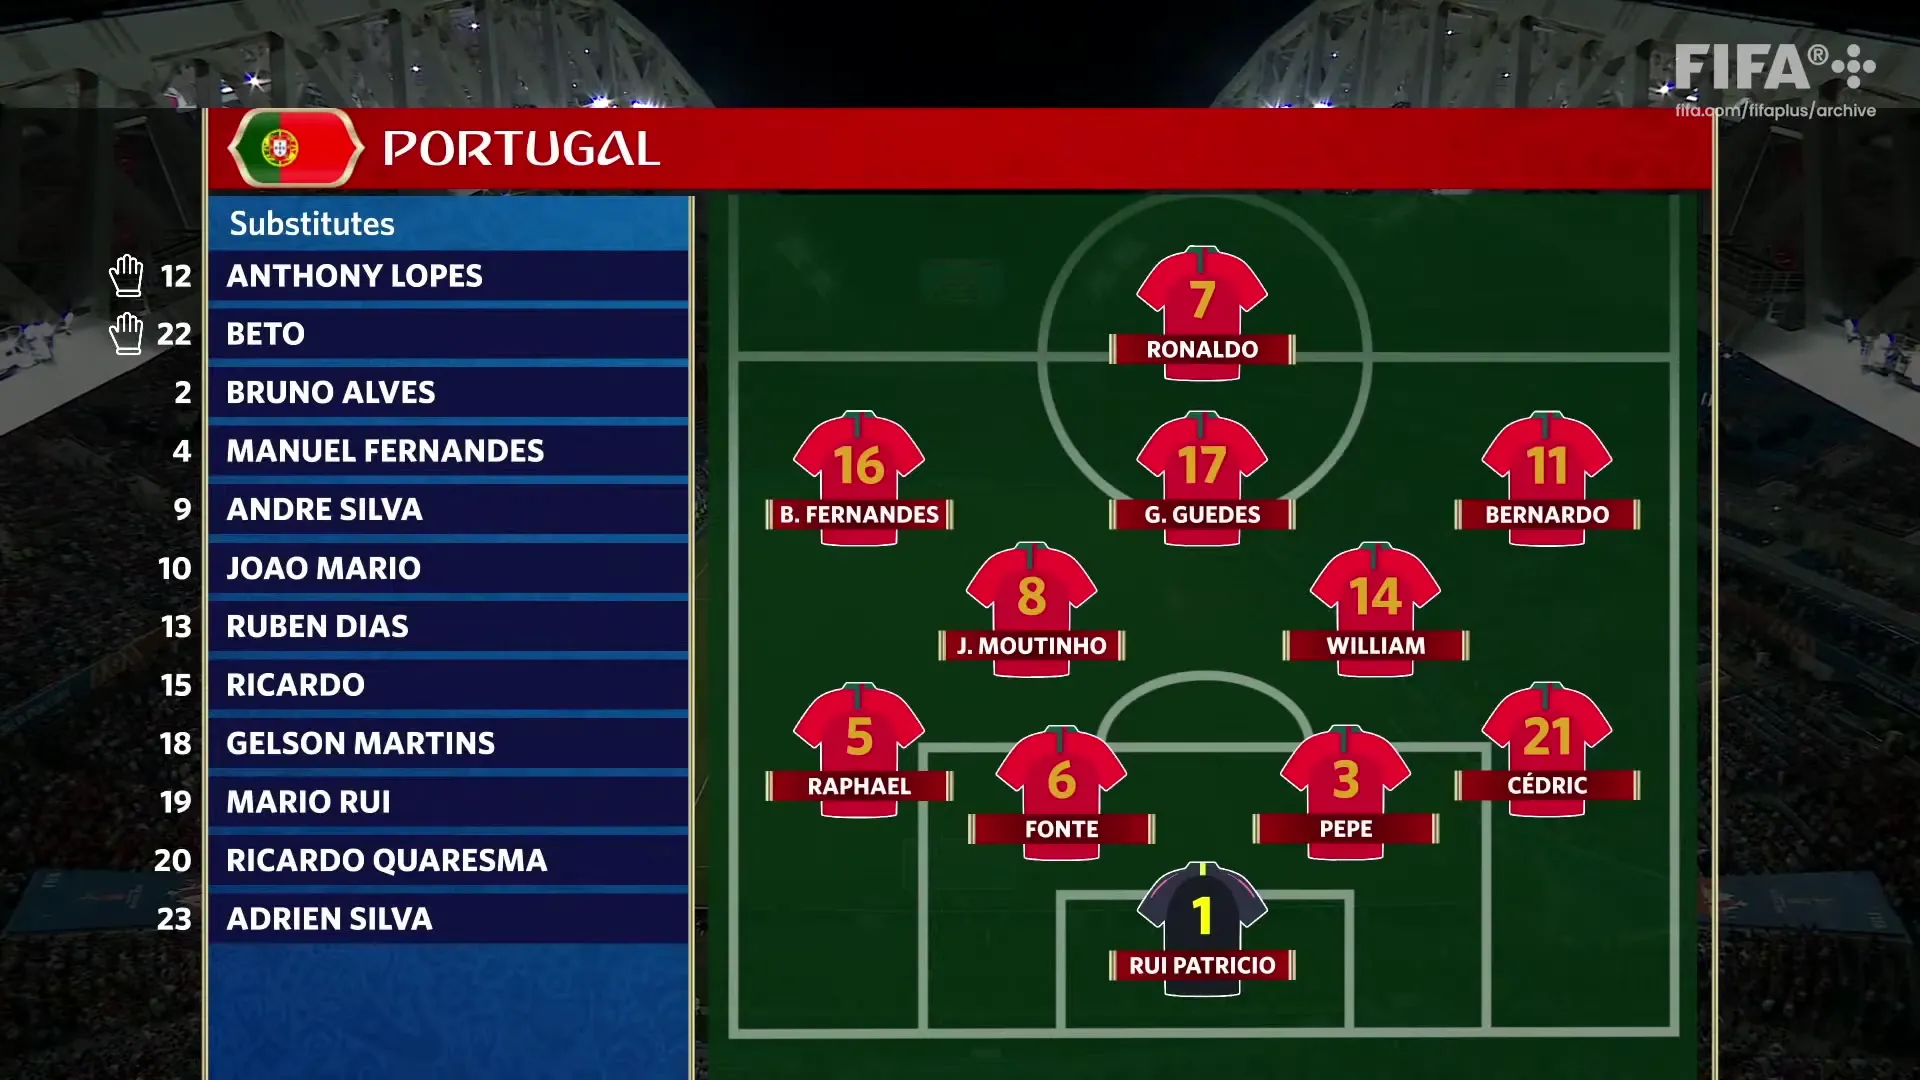

In [26]:
frames.select(
    frames.pos_msec,
    frames.frame
).show(2)

In [ ]:
# create udf that gets frame_pos, frame_posmsec, transcripts
# groups these two into by extracting transcript text only at that frame_pos + fps
# [frame_pos - 1sec, frame_pos + 1sec] interval
@pxt.udf
def group_sentence_by_frames(frame_pos_msec: pxt.type_system.Float, transcript: pxt.type_system.Json) -> pxt.type_system.String:
    relevant_text = ""
    frame_start_time = frame_pos_msec / 1e3
    frame_end_time = frame_pos_msec / 1e3 + 1

    for segment in transcript["segments"]:
        segment_start = segment["start"]
        segment_end = segment["end"]

        if segment_start < frame_end_time and segment_end > frame_start_time:
            relevant_text += segment["text"] + " "

    return relevant_text.strip()


frames.add_computed_column(
    sentence_by_frame=group_sentence_by_frames(frame_pos_msec=frames.pos_msec, transcript=frames.transcription), if_exists="replace"
)

Added 52 column values with 0 errors.


UpdateStatus(num_rows=52, num_computed_values=52, num_excs=0, updated_cols=[], cols_with_excs=[])

sentence_by_frame,frame,transcription_text
"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the",,"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're fourth with their talisman. It's their seventh World Cup in all. Jan-Luka Rokki from Italy is in charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials led by Massa Miliano Erati from Italy. David DeHaat was an ever-presenting qualifying. Many of this Spanish team we know."
"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the",,"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're fourth with their talisman. It's their seventh World Cup in all. Jan-Luka Rokki from Italy is in charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials led by Massa Miliano Erati from Italy. David DeHaat was an ever-presenting qualifying. Many of this Spanish team we know."
"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the",,"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're fourth with their talisman. It's their seventh World Cup in all. Jan-Luka Rokki from Italy is in charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials led by Massa Miliano Erati from Italy. David DeHaat was an ever-presenting qualifying. Many of this Spanish team we know."
"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the",,"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're fourth with their talisman. It's their seventh World Cup in all. Jan-Luka Rokki from Italy is in charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials led by Massa Miliano Erati from Italy. David DeHaat was an ever-presenting qualifying. Many of this Spanish team we know."
"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the",,"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're fourth with their talisman. It's their seventh World Cup in all. Jan-Luka Rokki from Italy is in charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials led by Massa Miliano Erati from Italy. David DeHaat was an ever-presenting qualifying. Many of this Spanish team we know."
"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal",,"at eight days ago. Portugal regularly used a 4-4-2 formation in qualifying, where the gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo tha
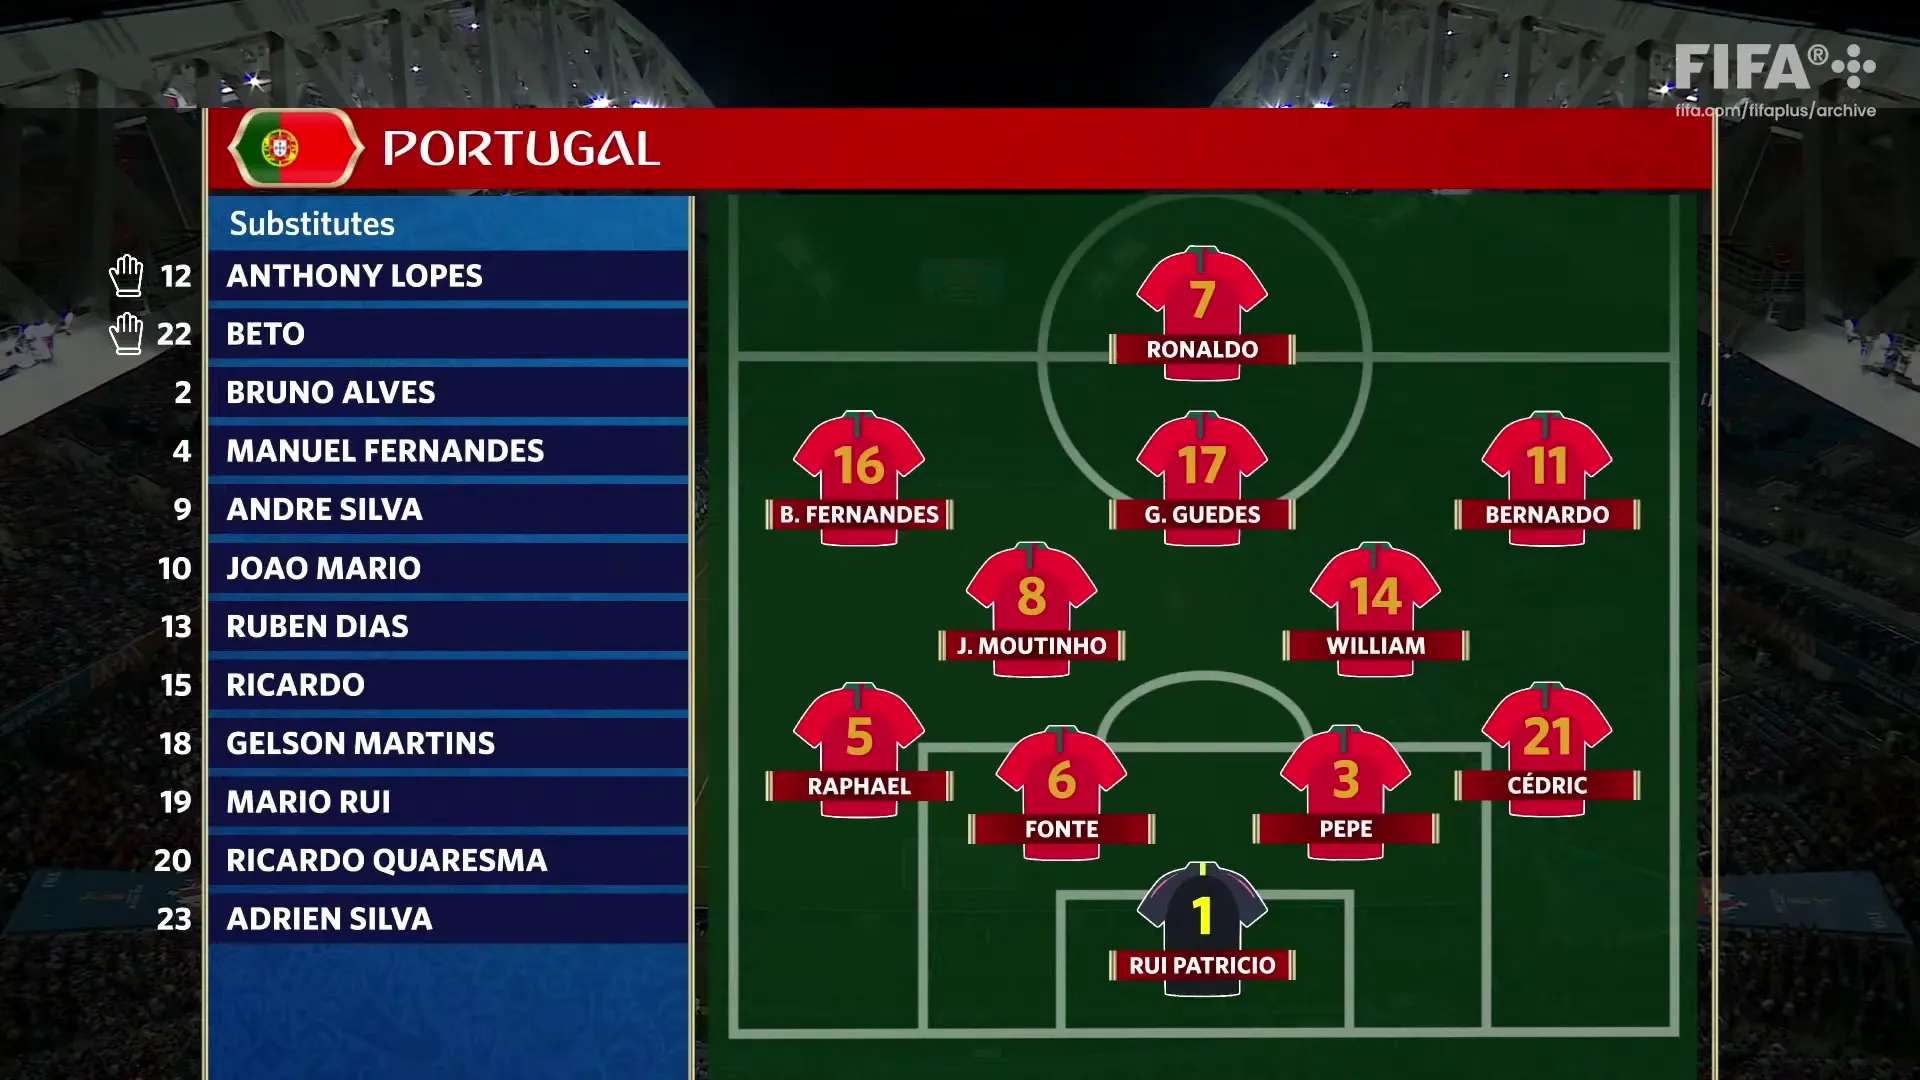
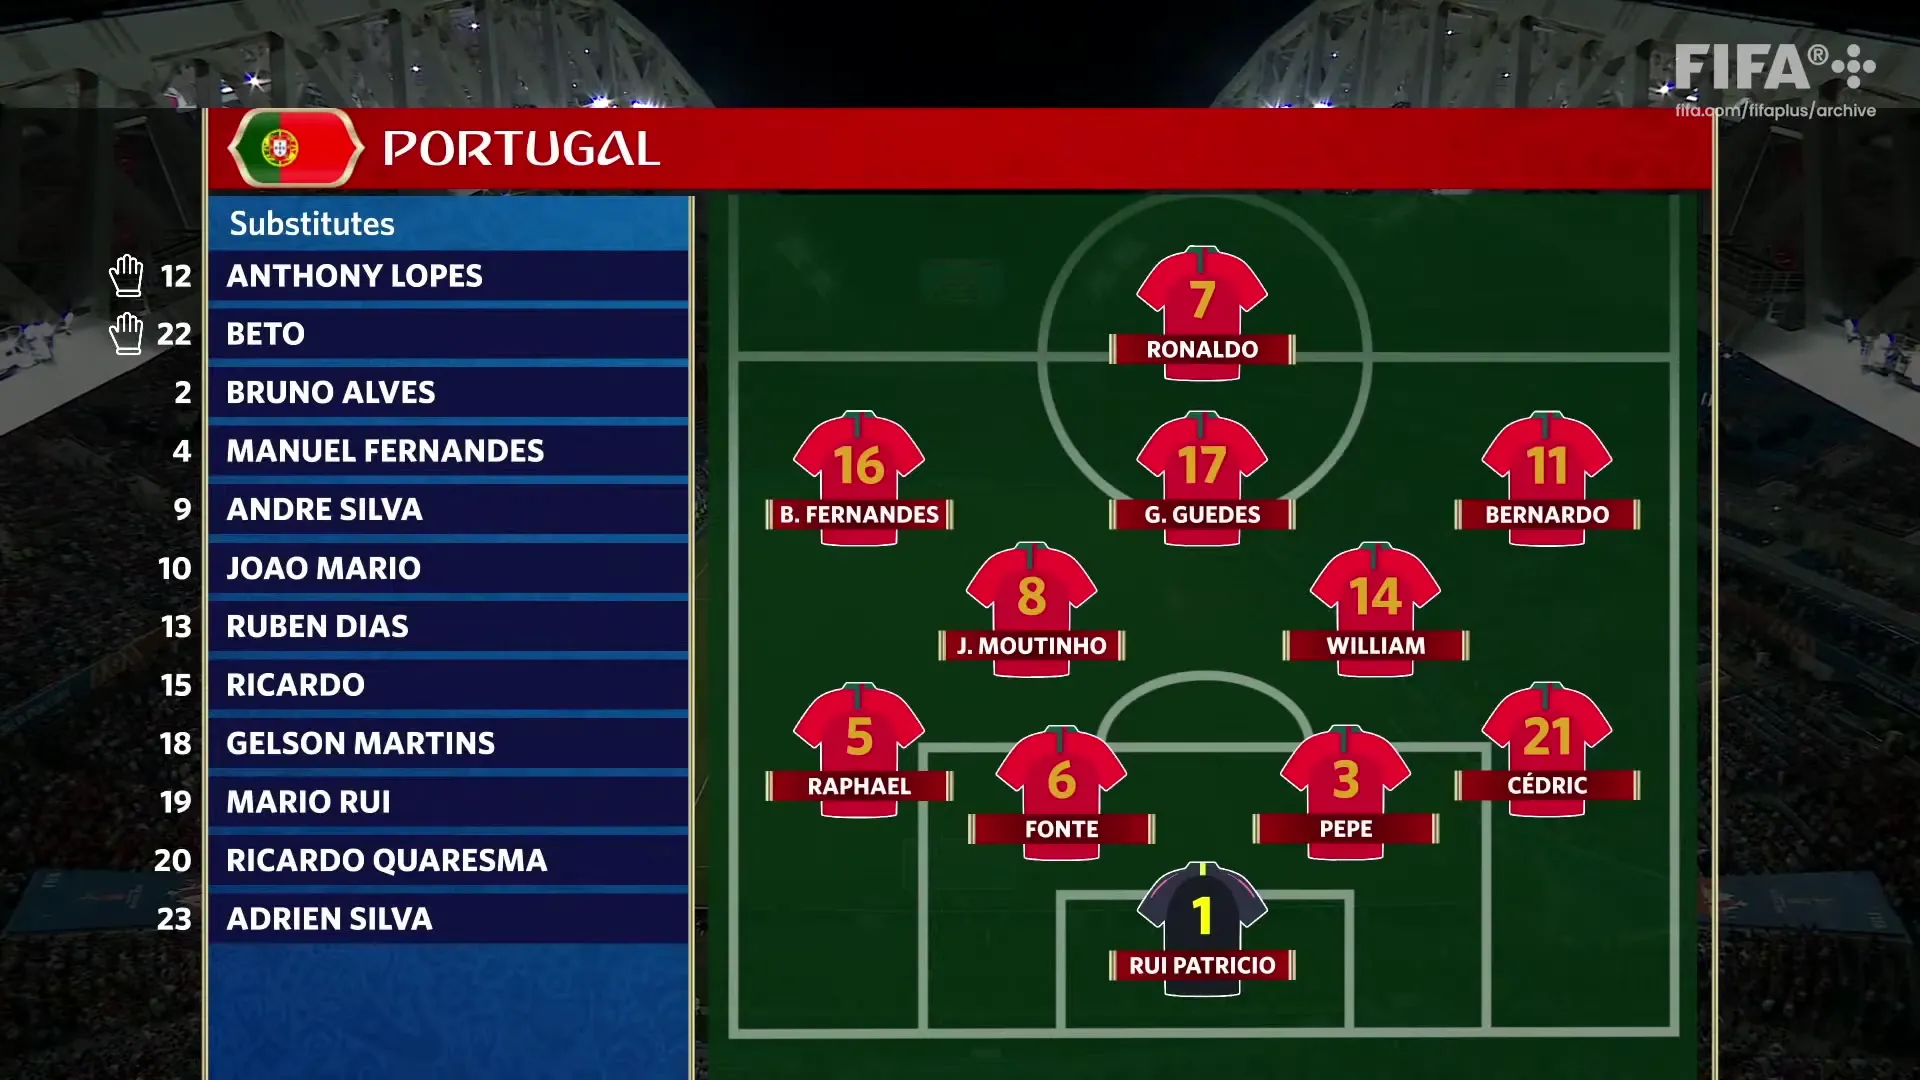
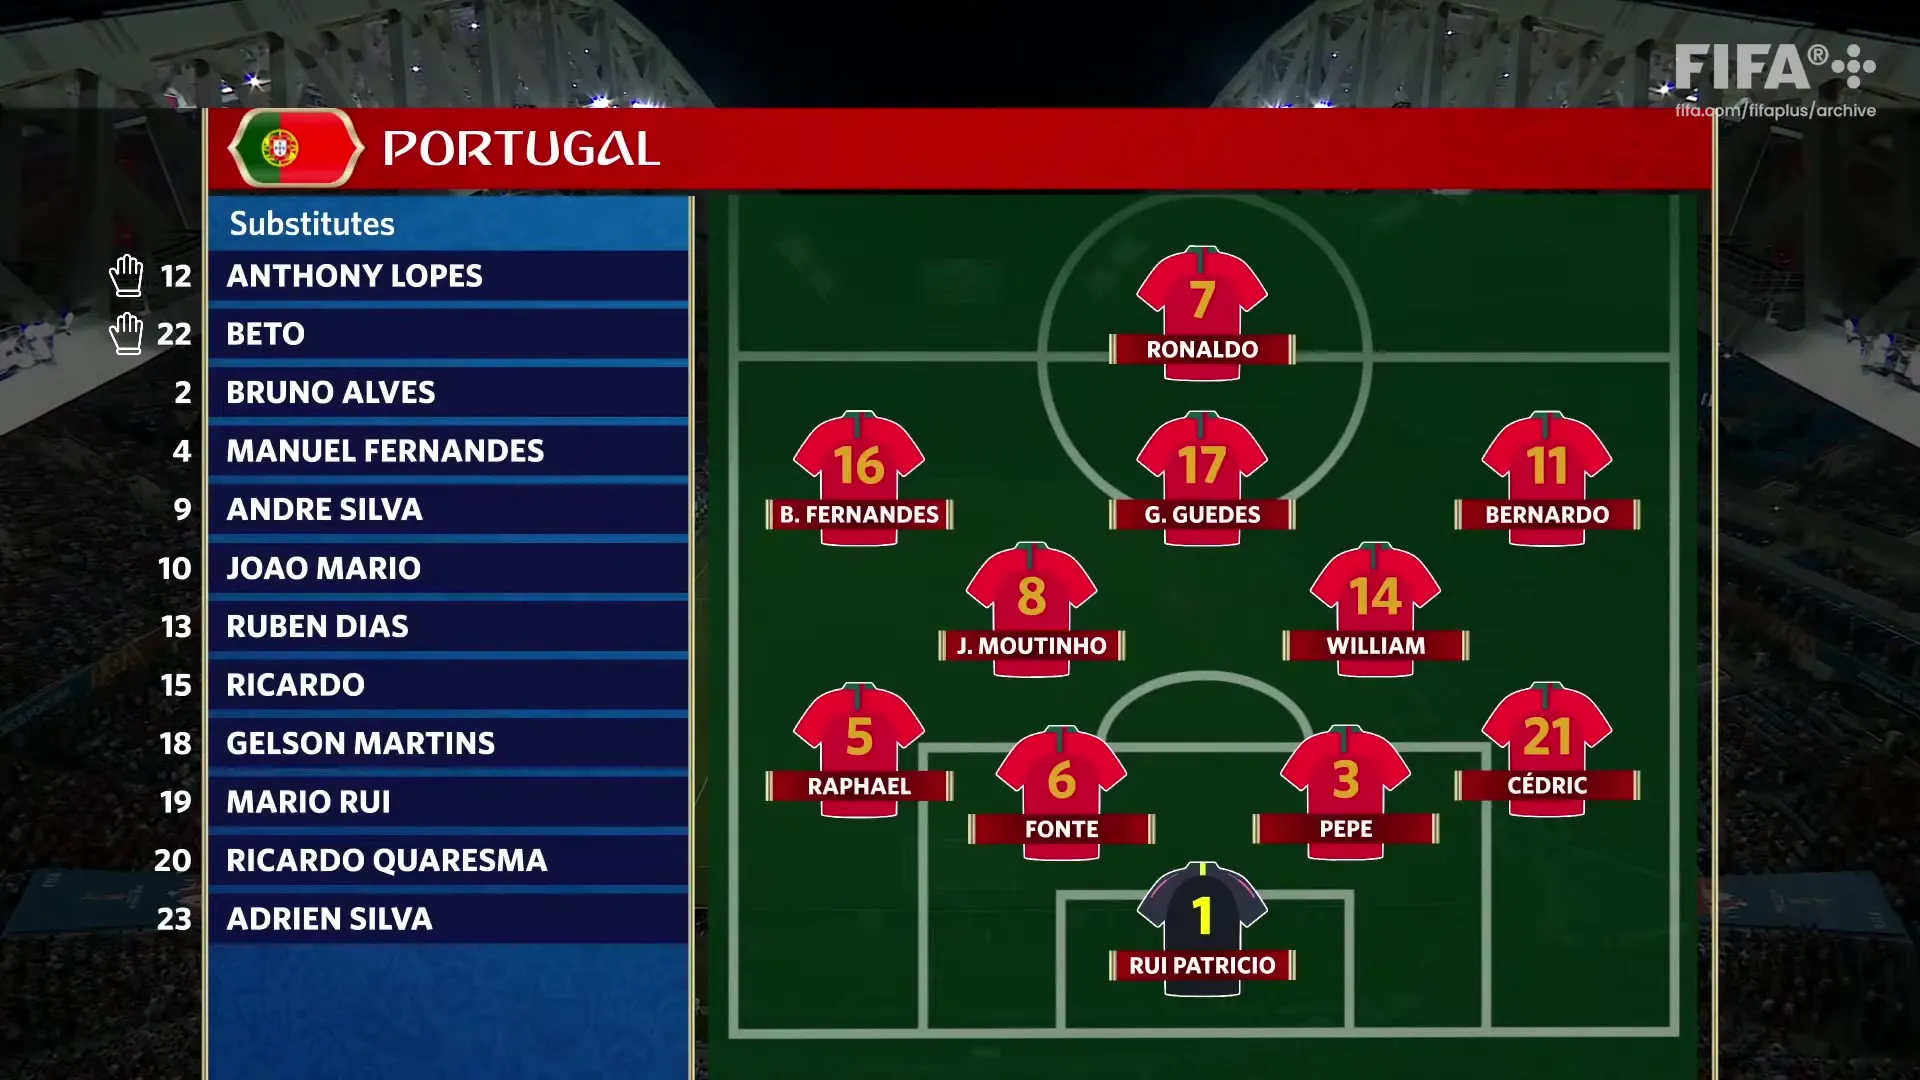
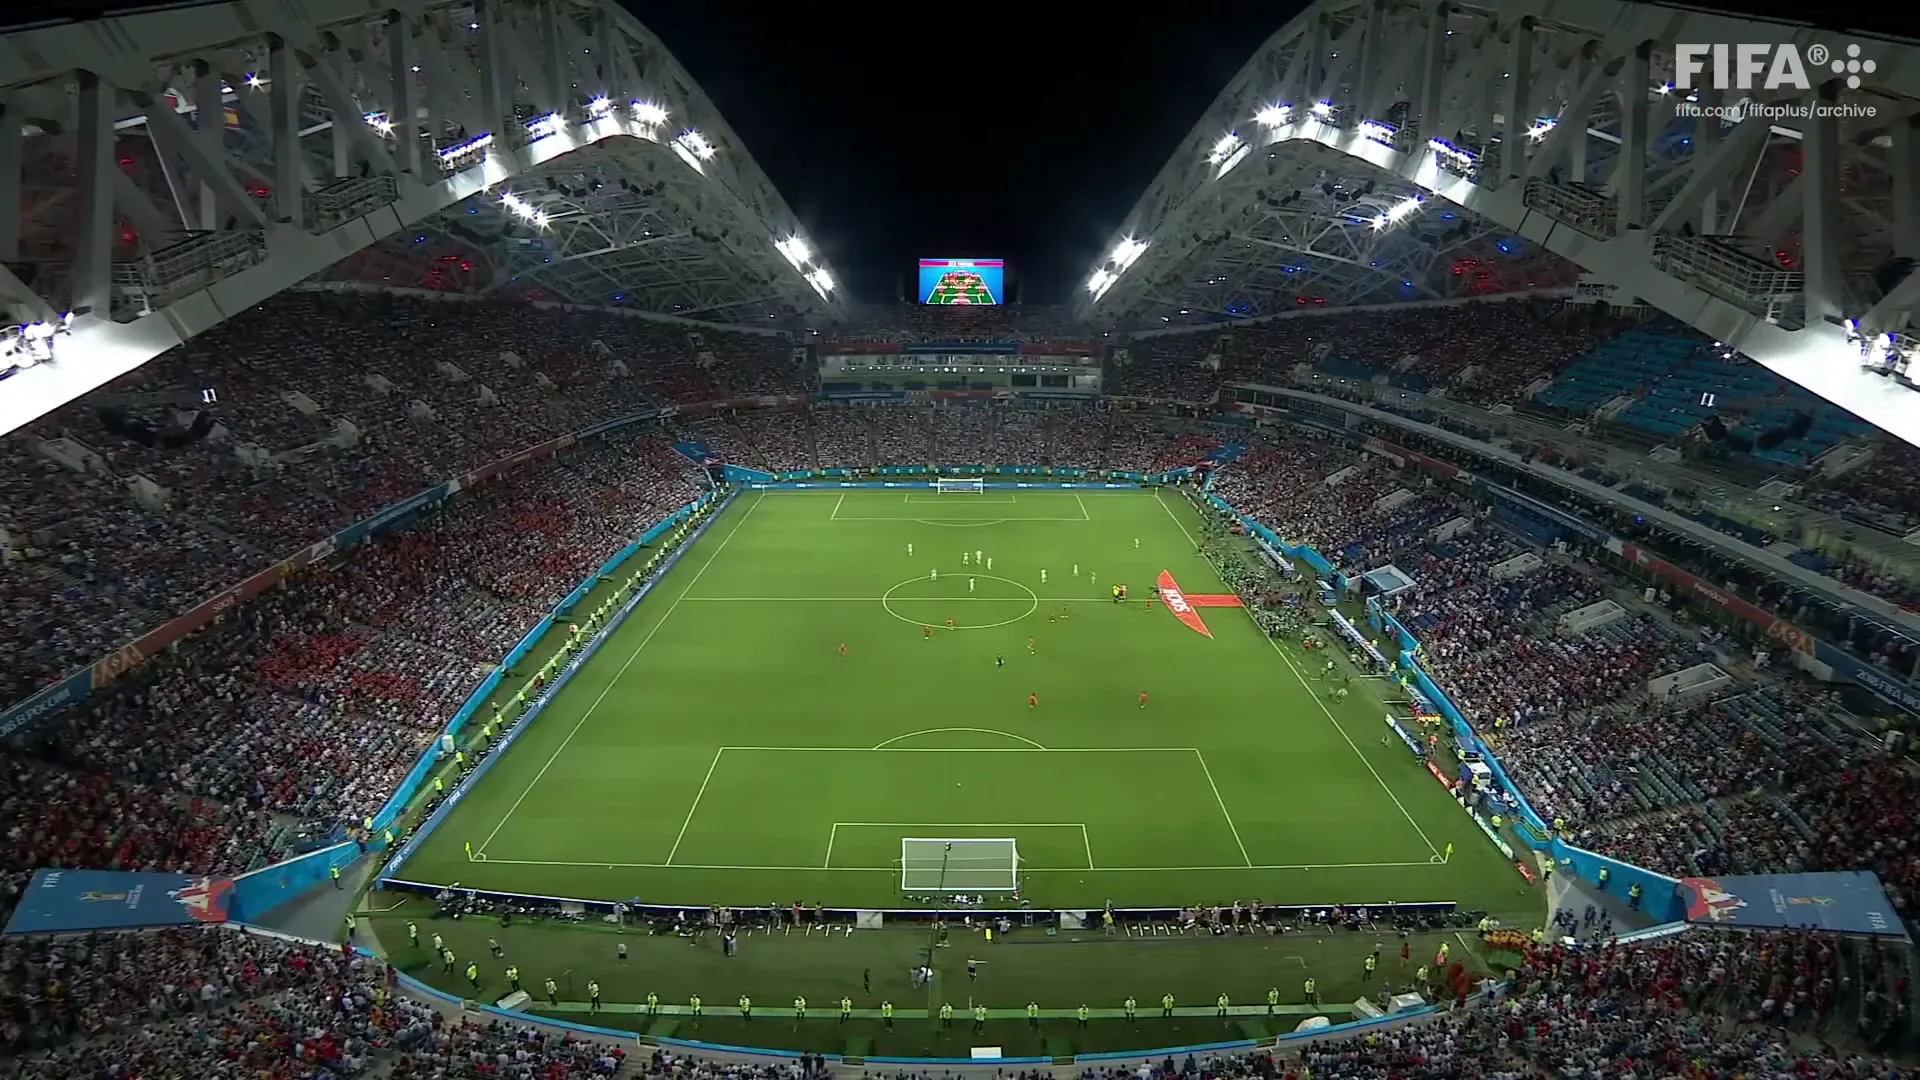
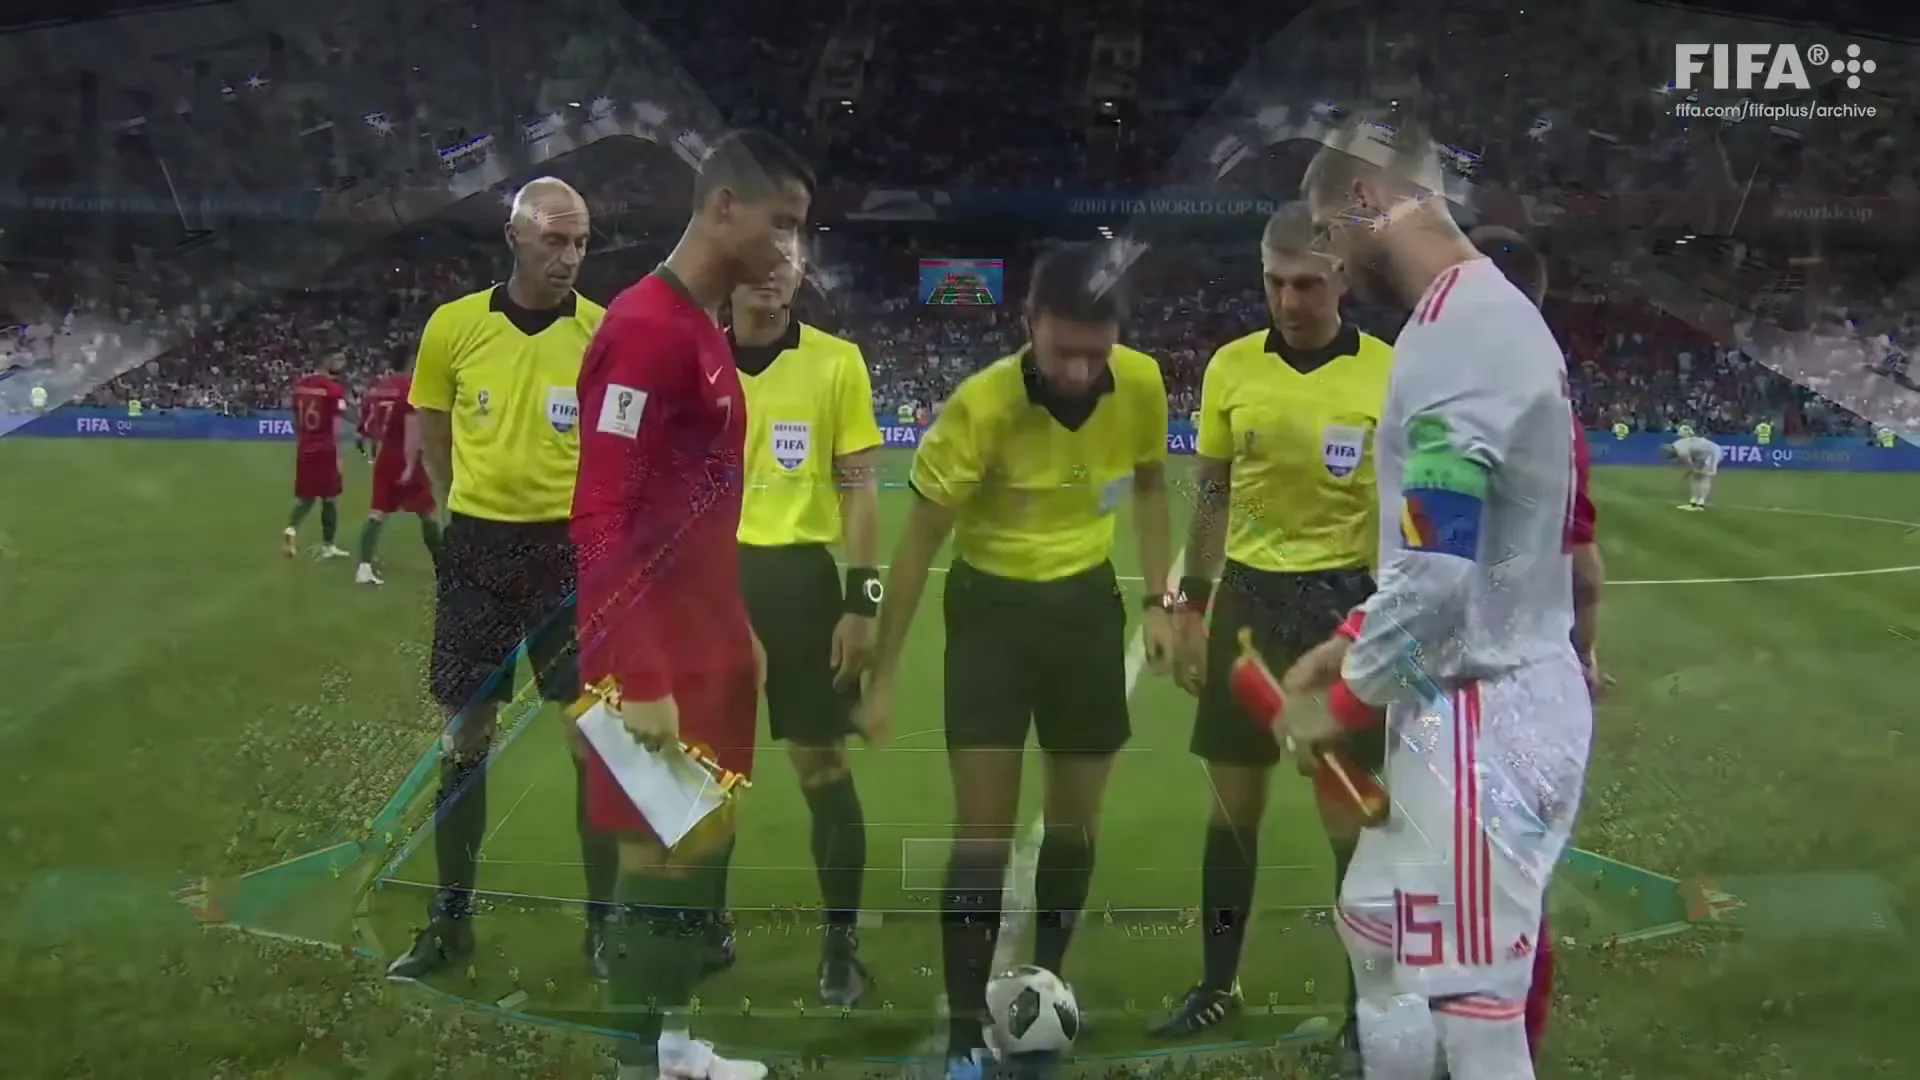
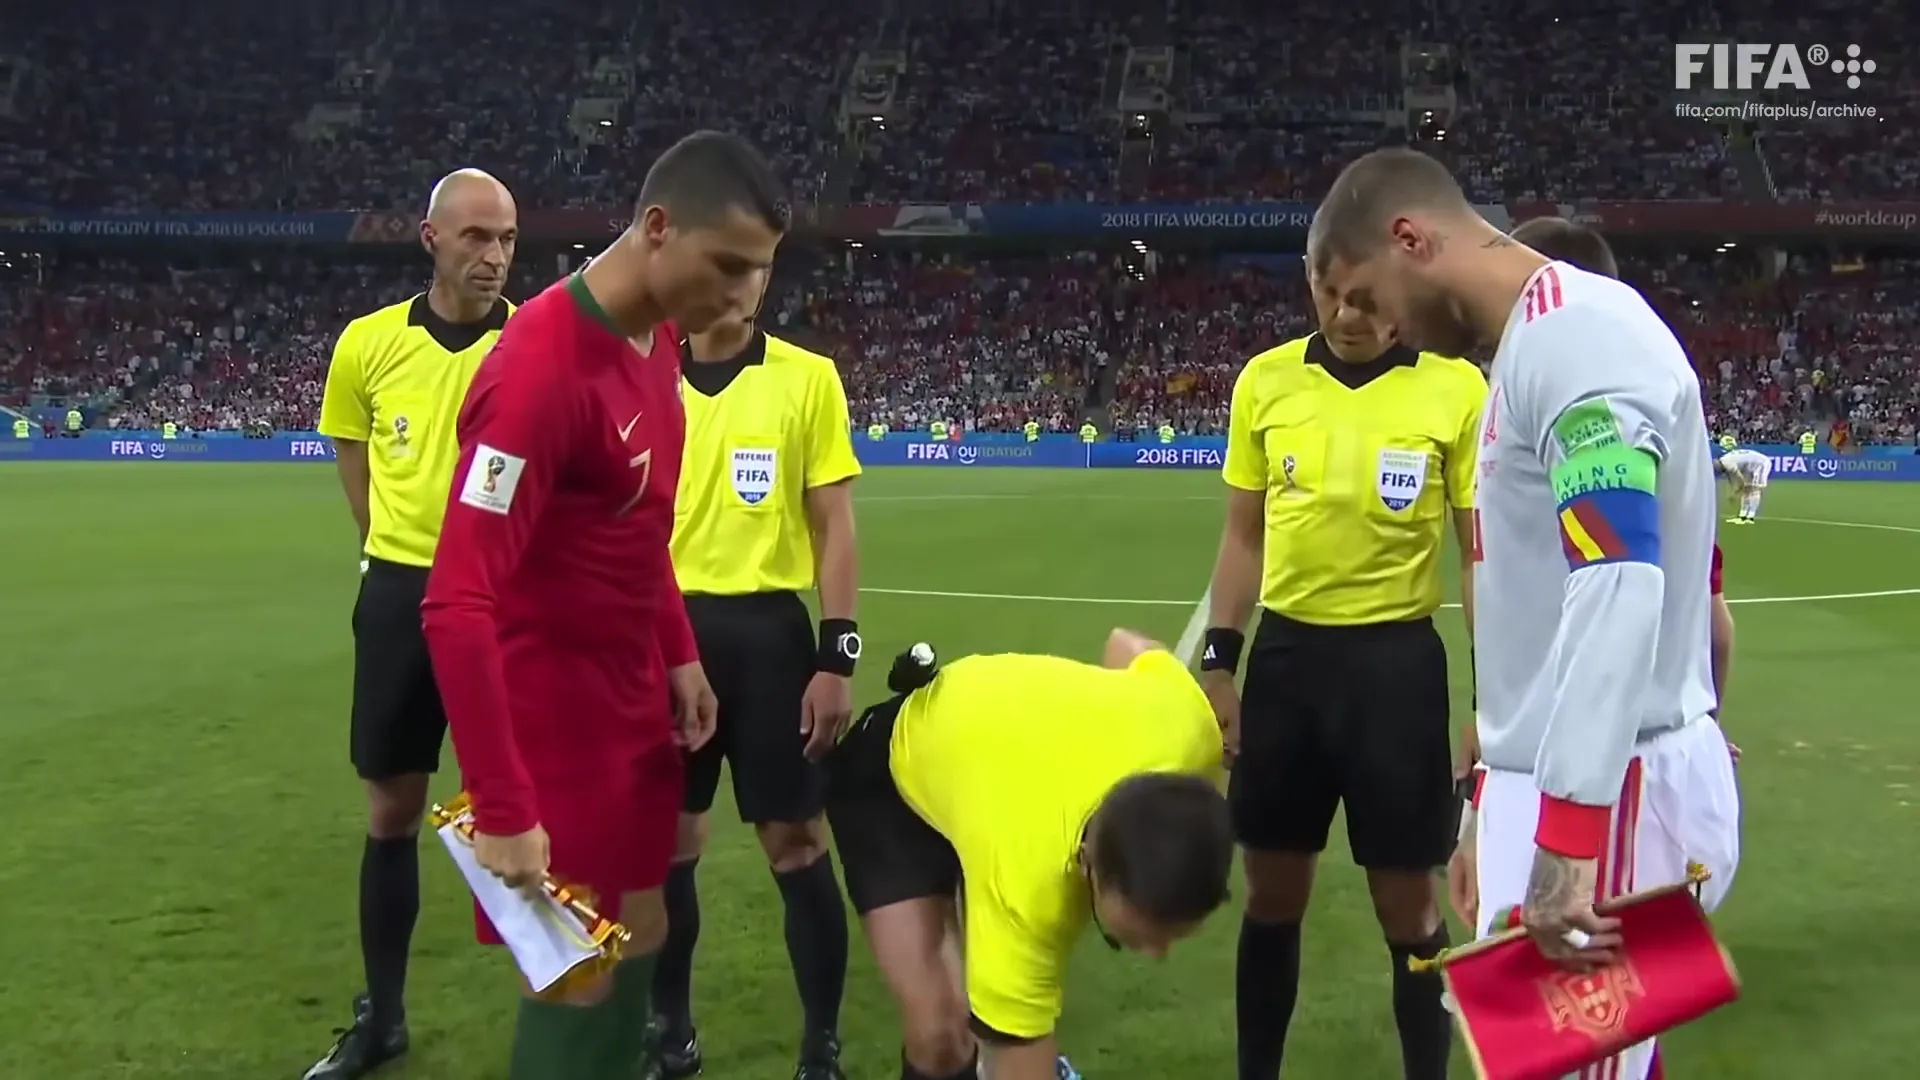
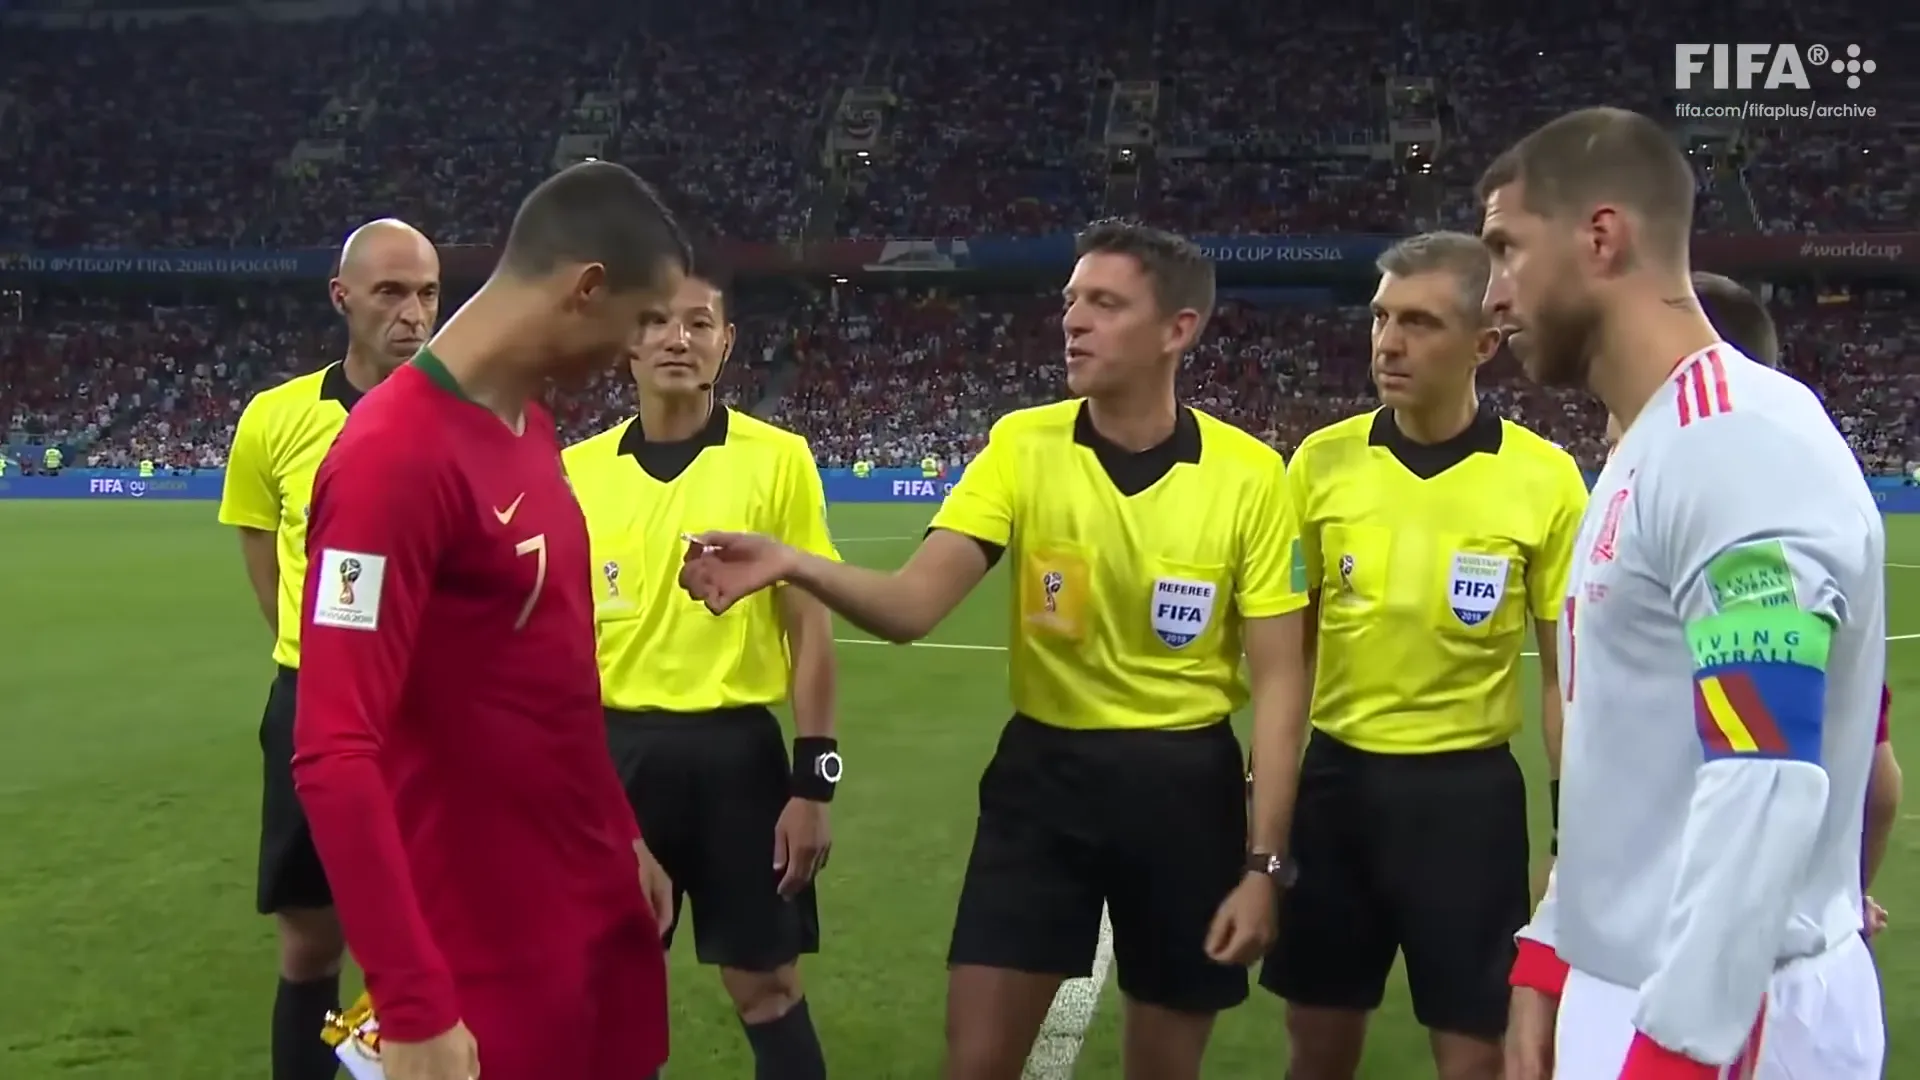
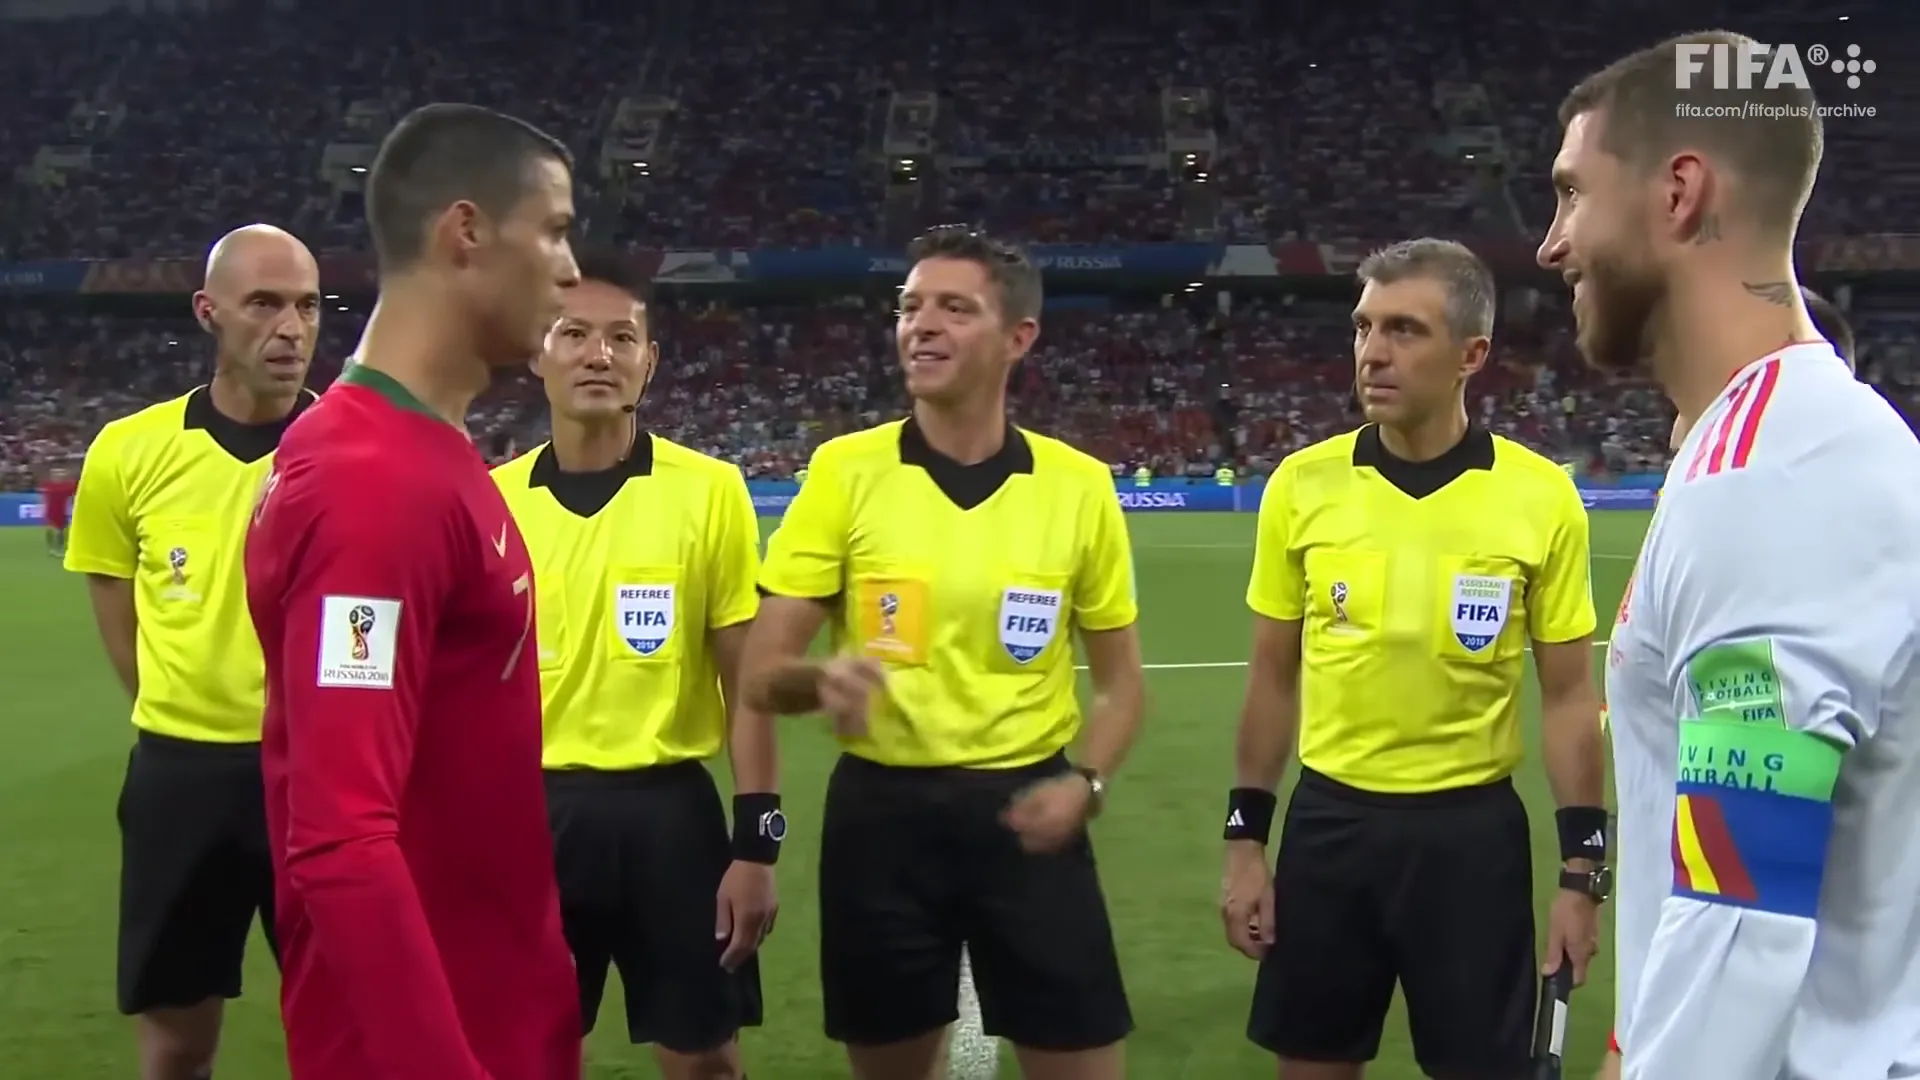
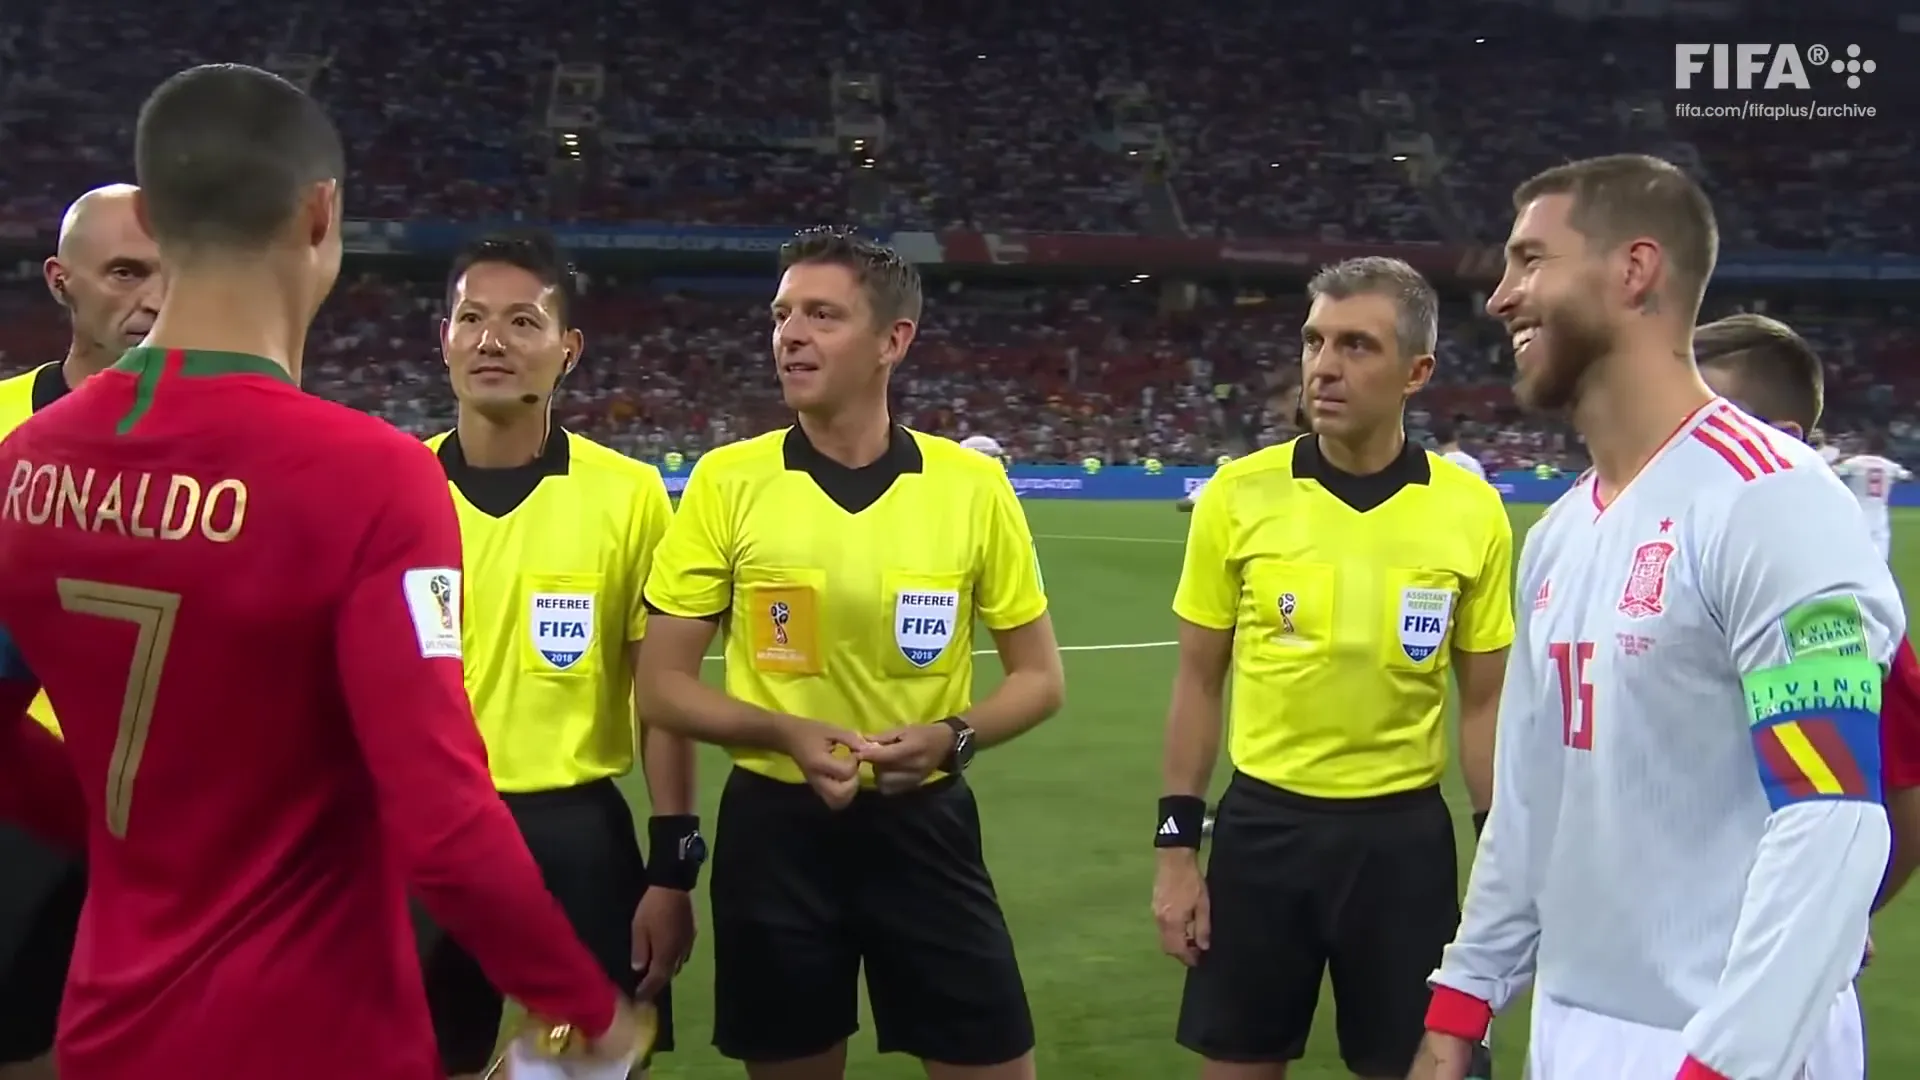
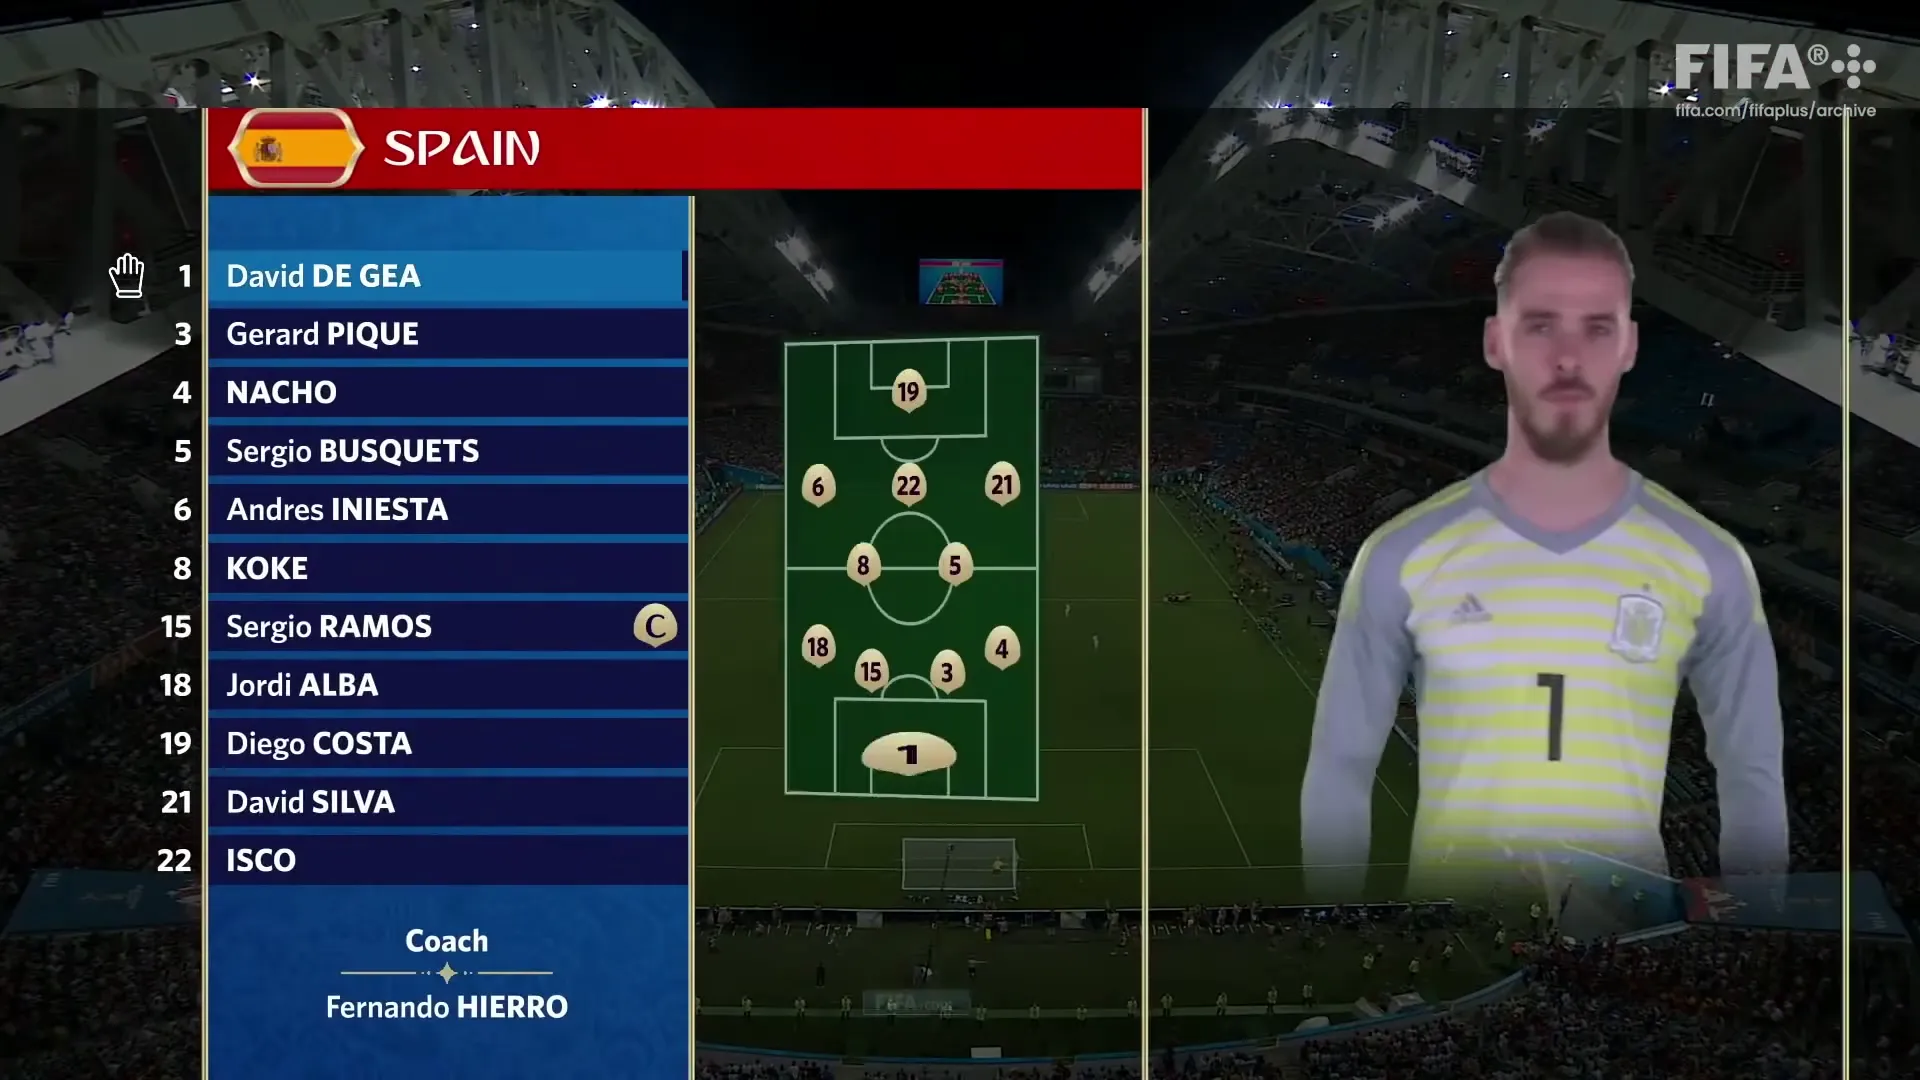

In [30]:
frames.select(frames.sentence_by_frame, frames.frame, frames.transcription.text).show(10)

In [33]:
from pixeltable.functions.huggingface import sentence_transformer
frames.add_embedding_index(
    column=frames.sentence_by_frame,
    string_embed=sentence_transformer.using(model_id="intfloat/e5-large-v2"),
    if_exists="replace",
)


sentence_by_frame,frame,similarity
have played in more World Cups with Cristiano Ronaldo than without. They're fourth with,,0.821
have played in more World Cups with Cristiano Ronaldo than without. They're fourth with,,0.821
have played in more World Cups with Cristiano Ronaldo than without. They're fourth with,,0.821
have played in more World Cups with Cristiano Ronaldo than without. They're fourth with,,0.821
have played in more World Cups with Cristiano Ronaldo than without. They're fourth with their talisman. It's their seventh World Cup in all. Jan-Luka Rokki from Italy is in,,0.815
gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're fourth with,,0.814
gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal,,0.802
gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal,,0.802
gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal,,0.802
gay dash plays just behind Ronaldo or alongside him. We will just have to wait and see. Portugal,,0.802

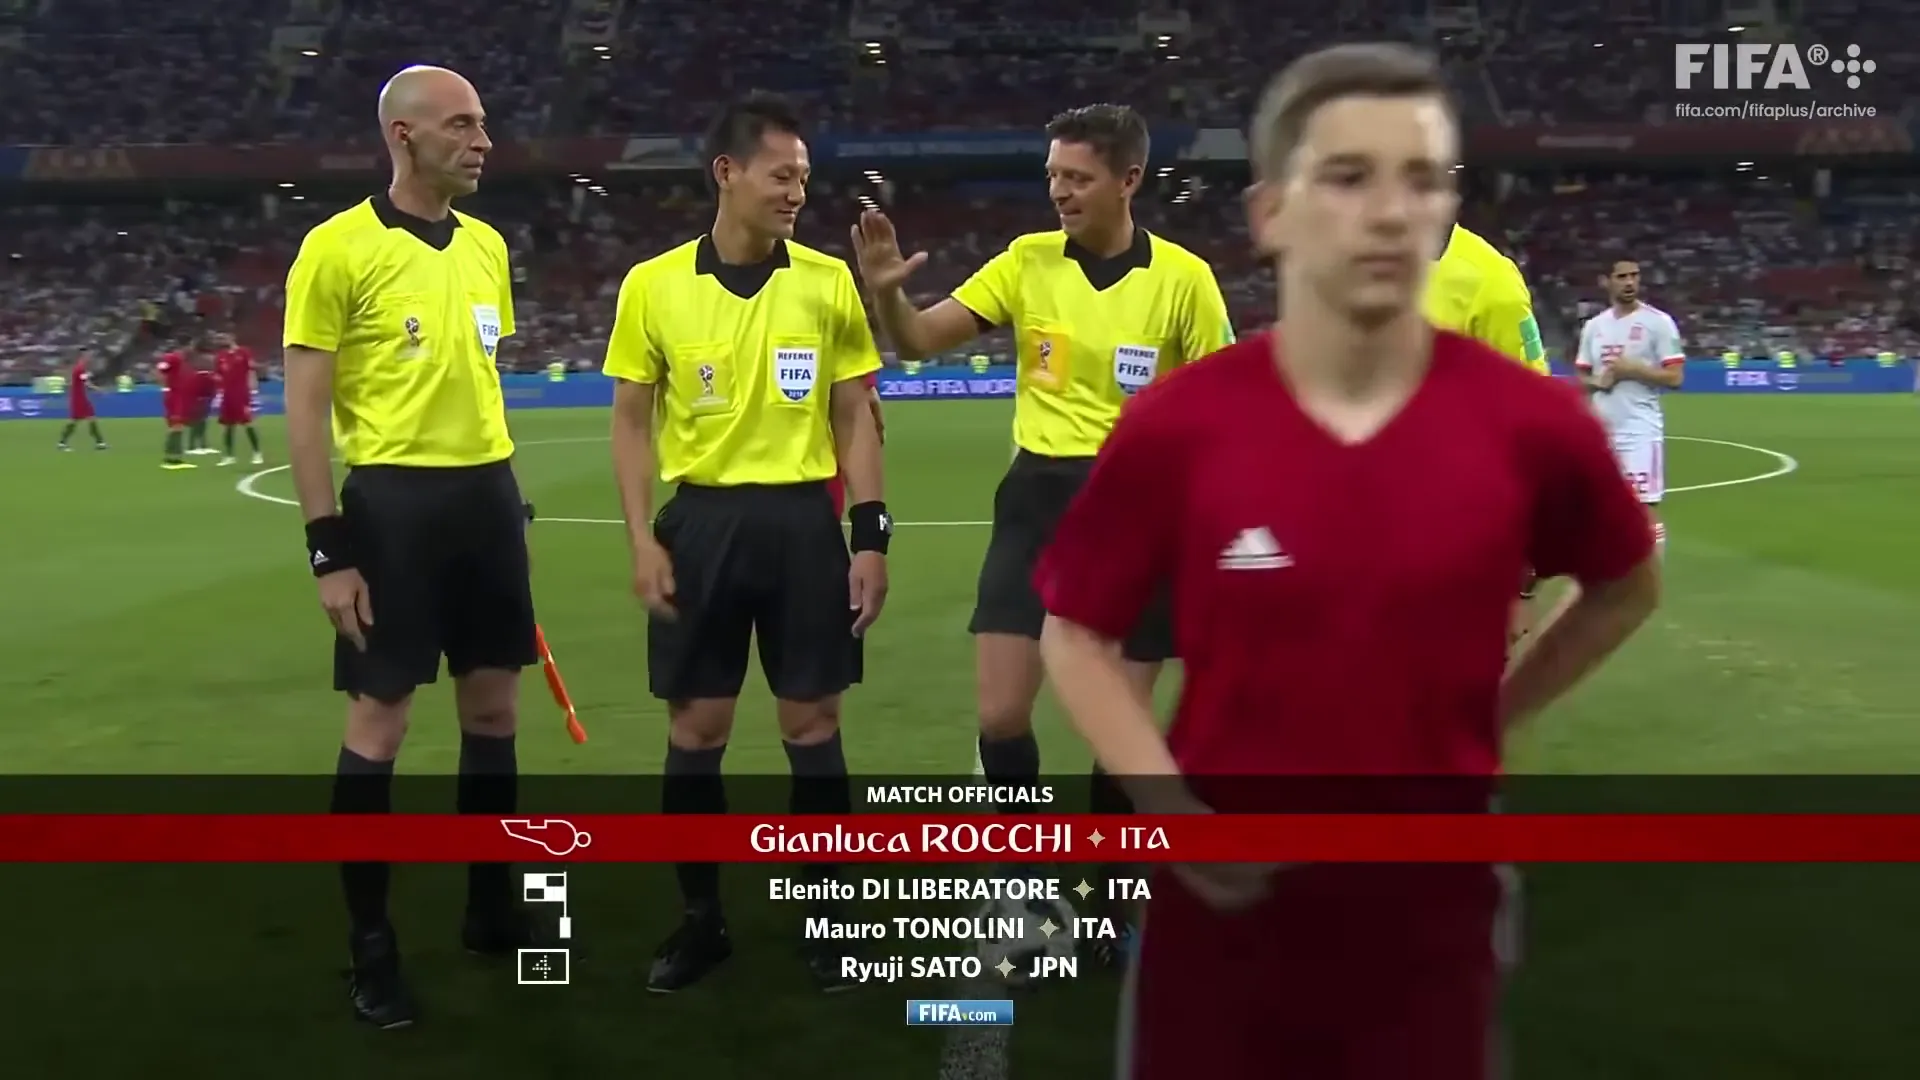
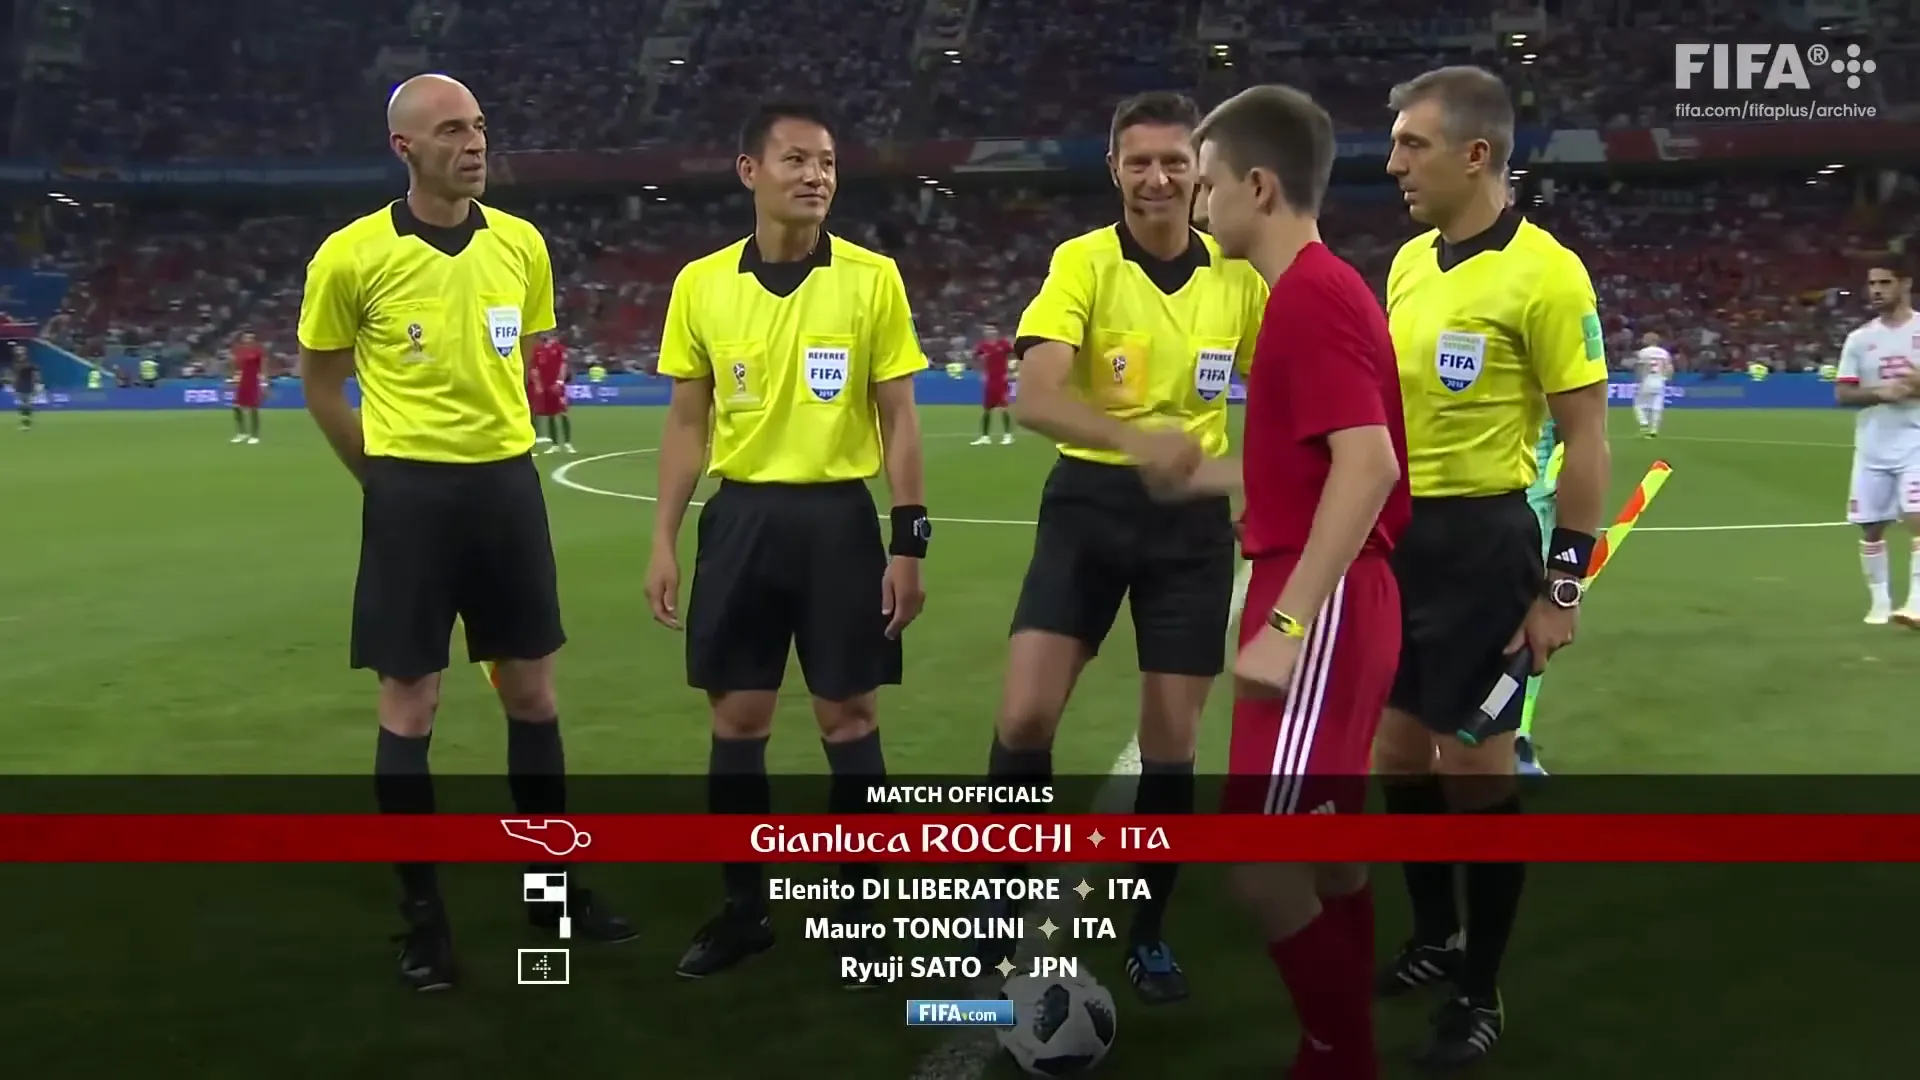
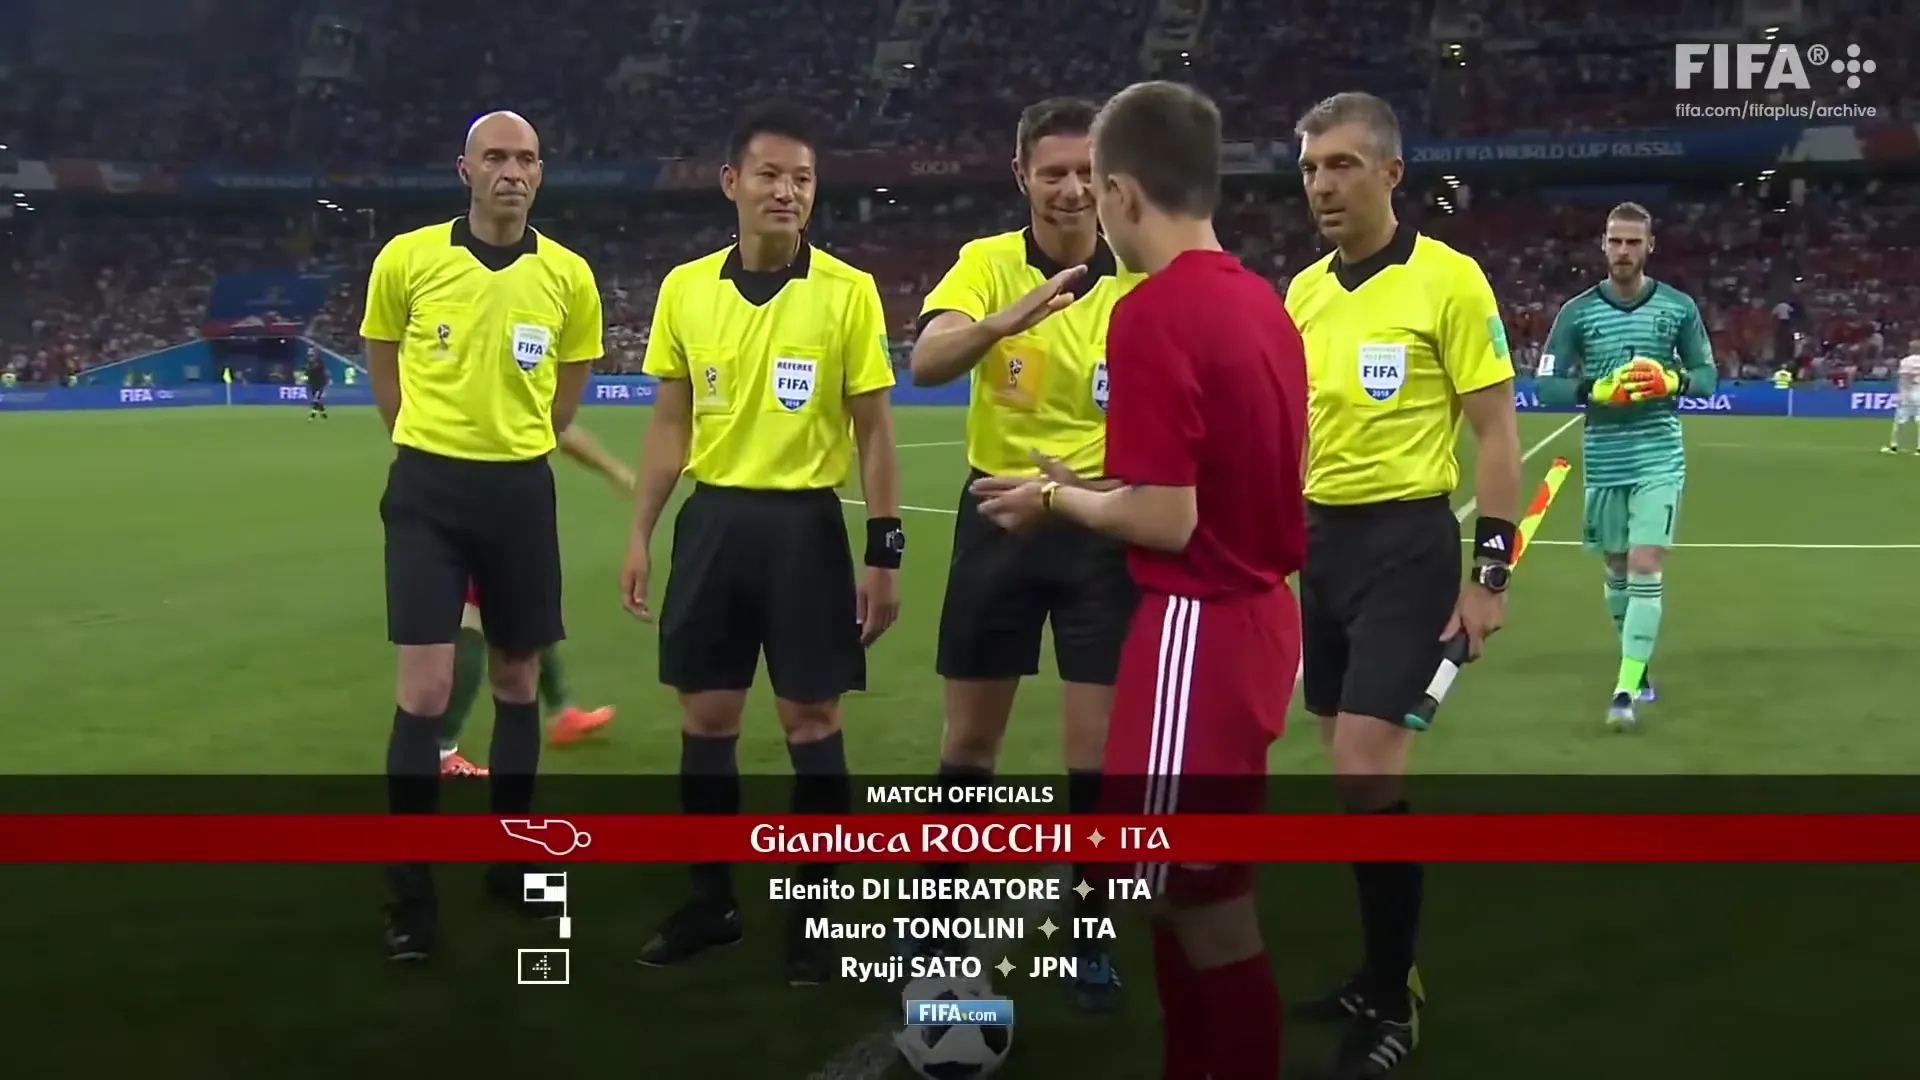
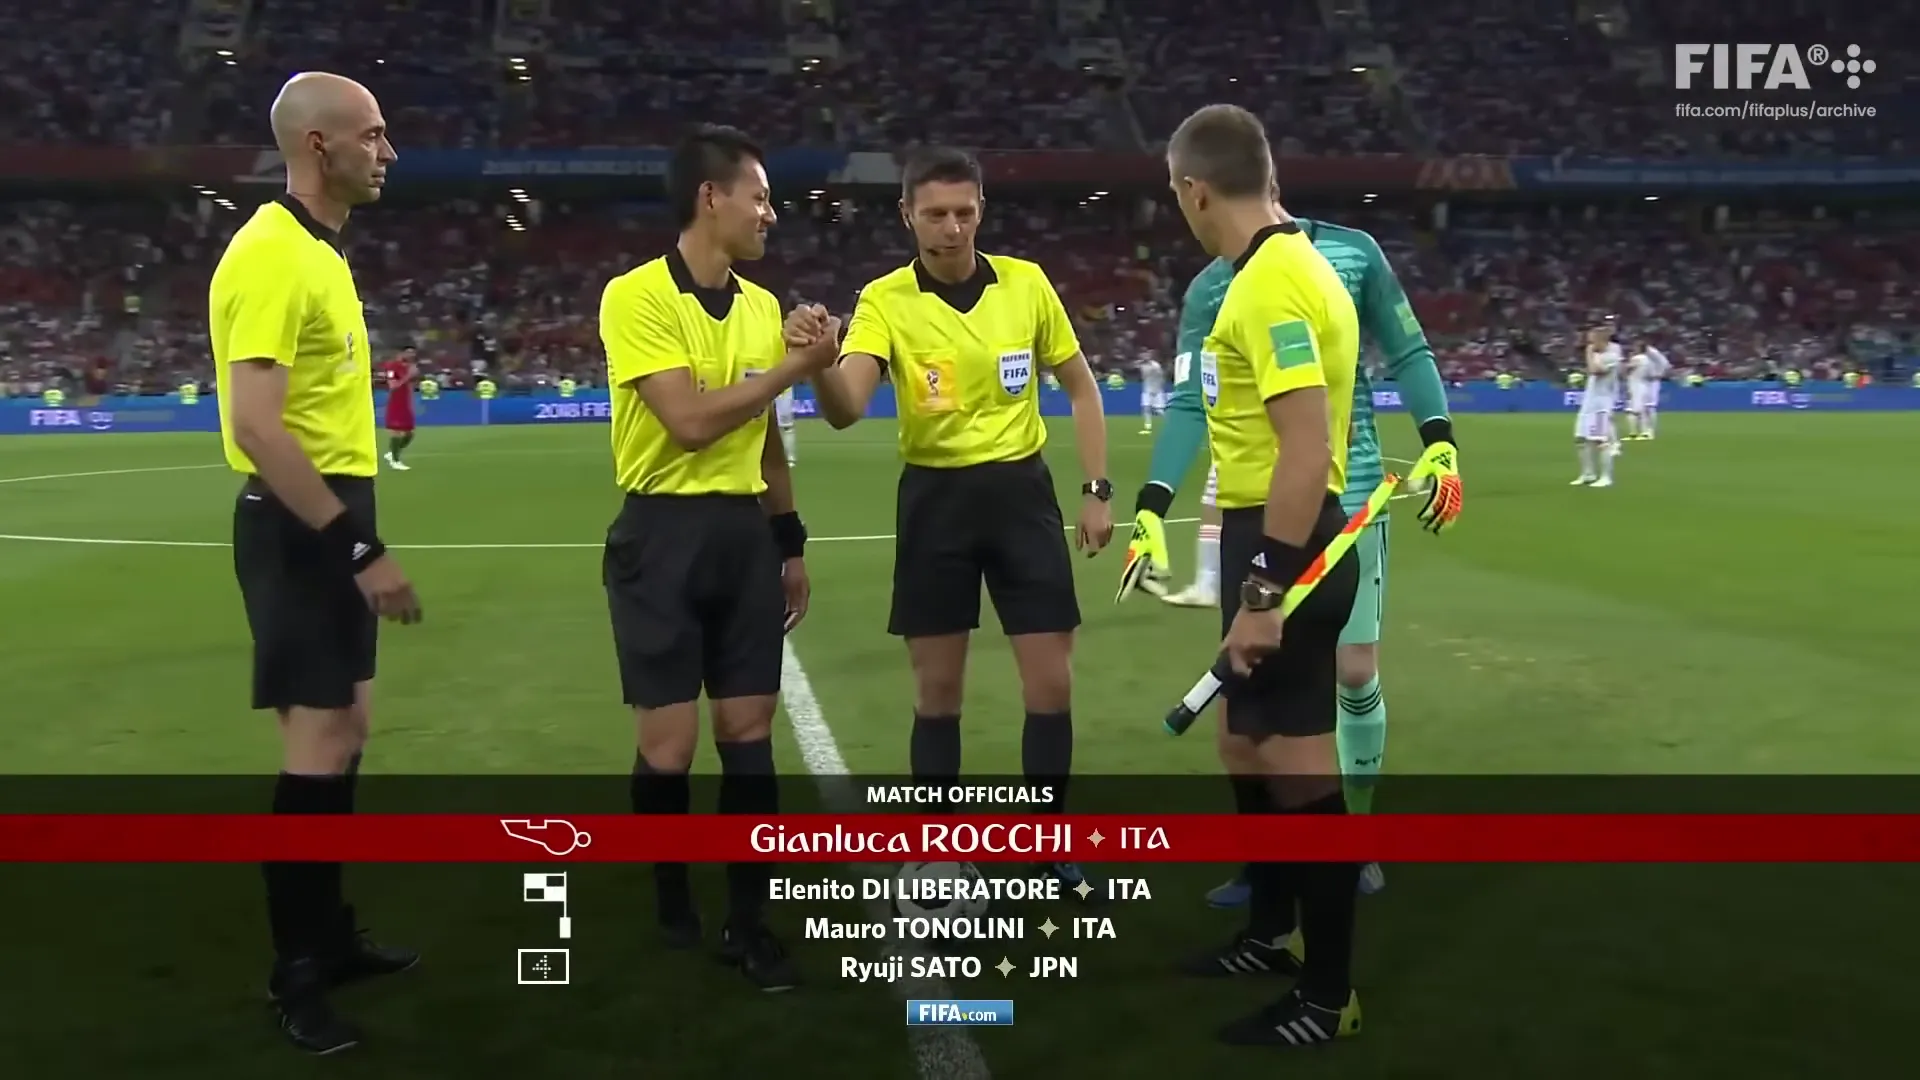
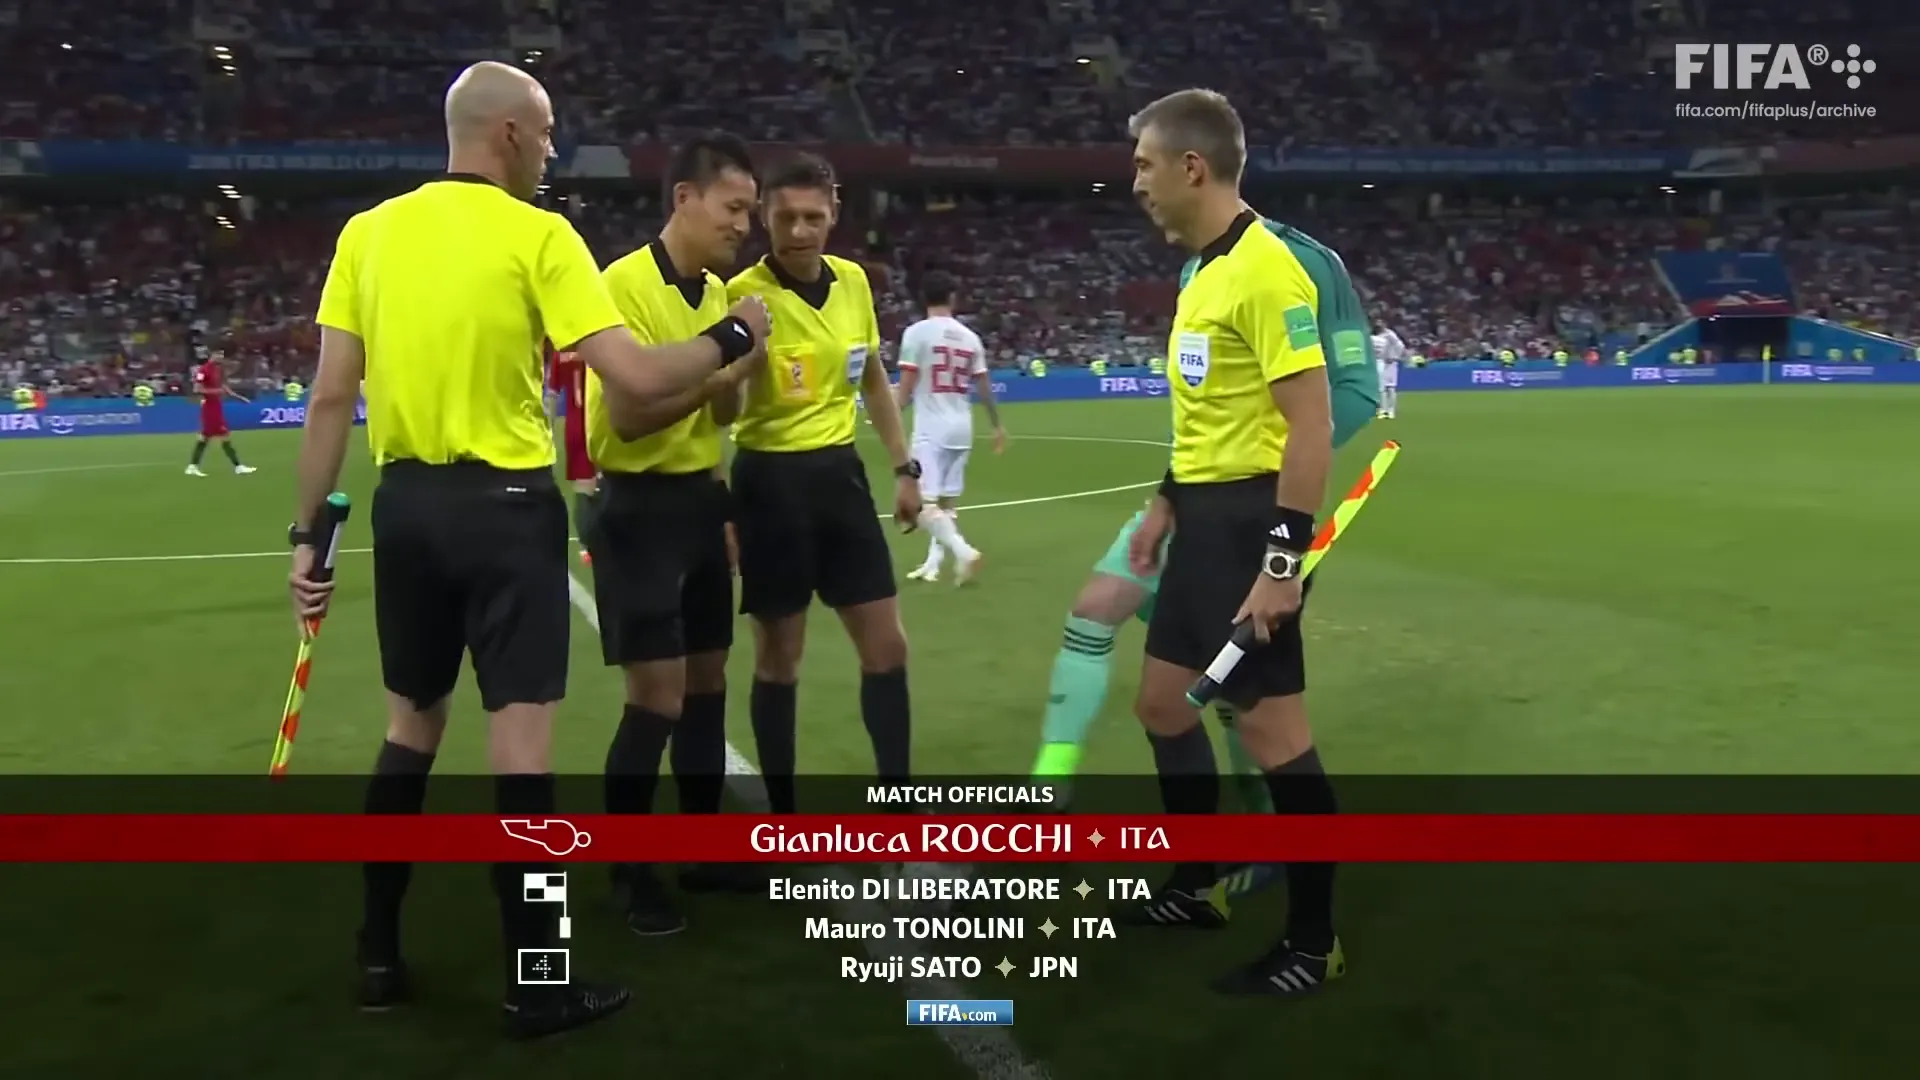
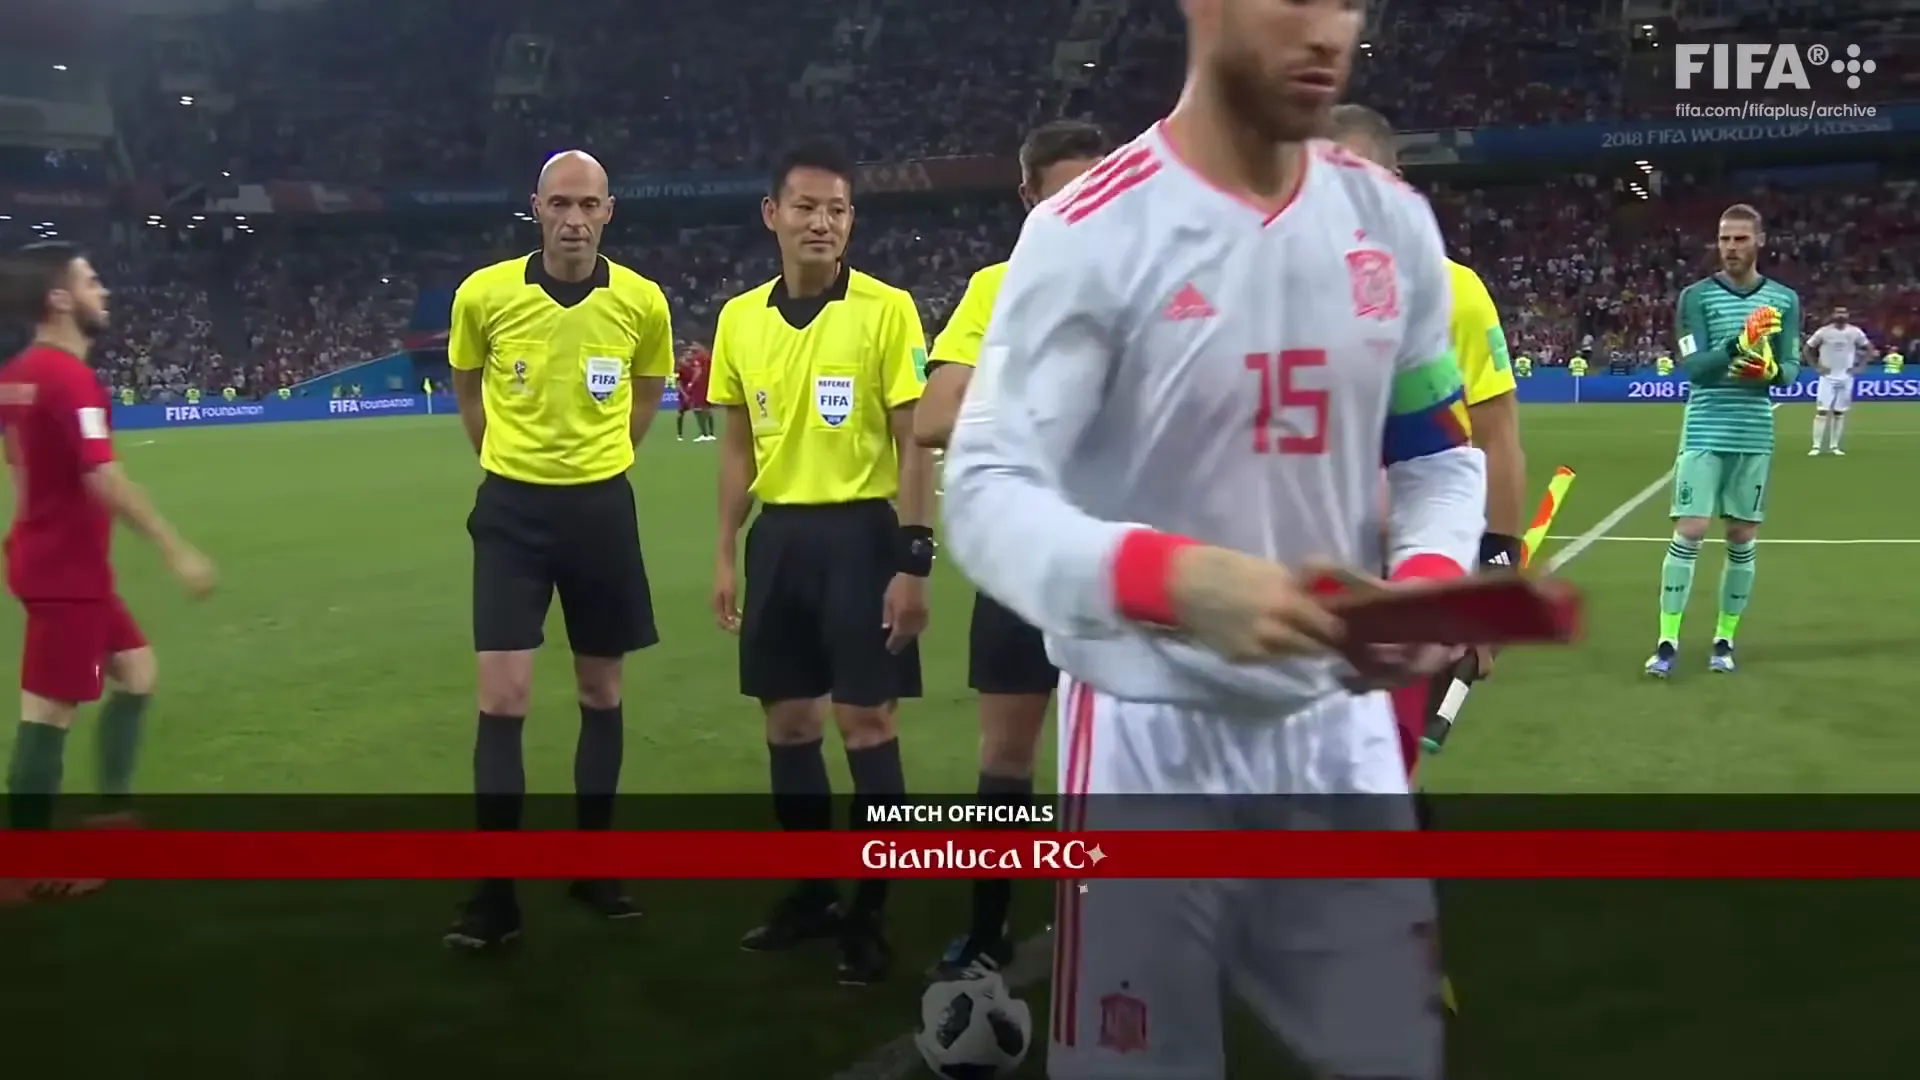
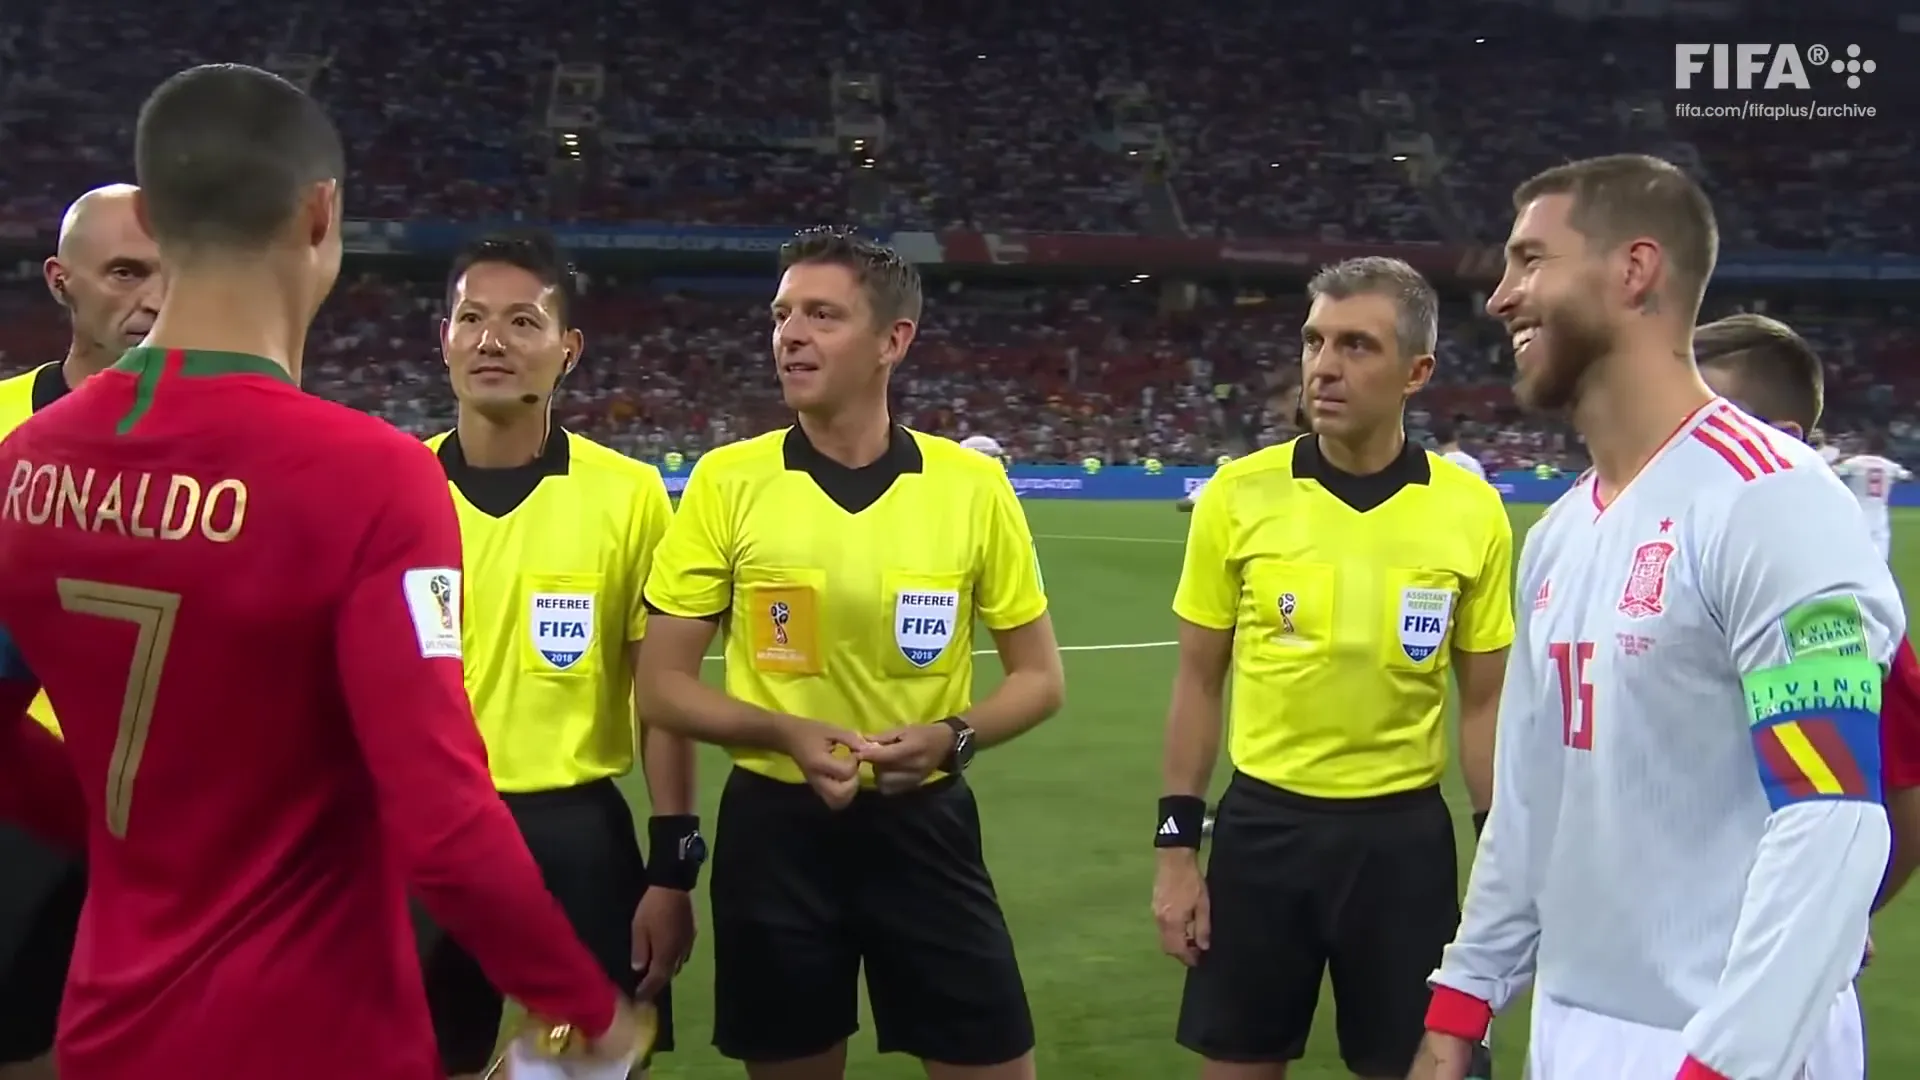
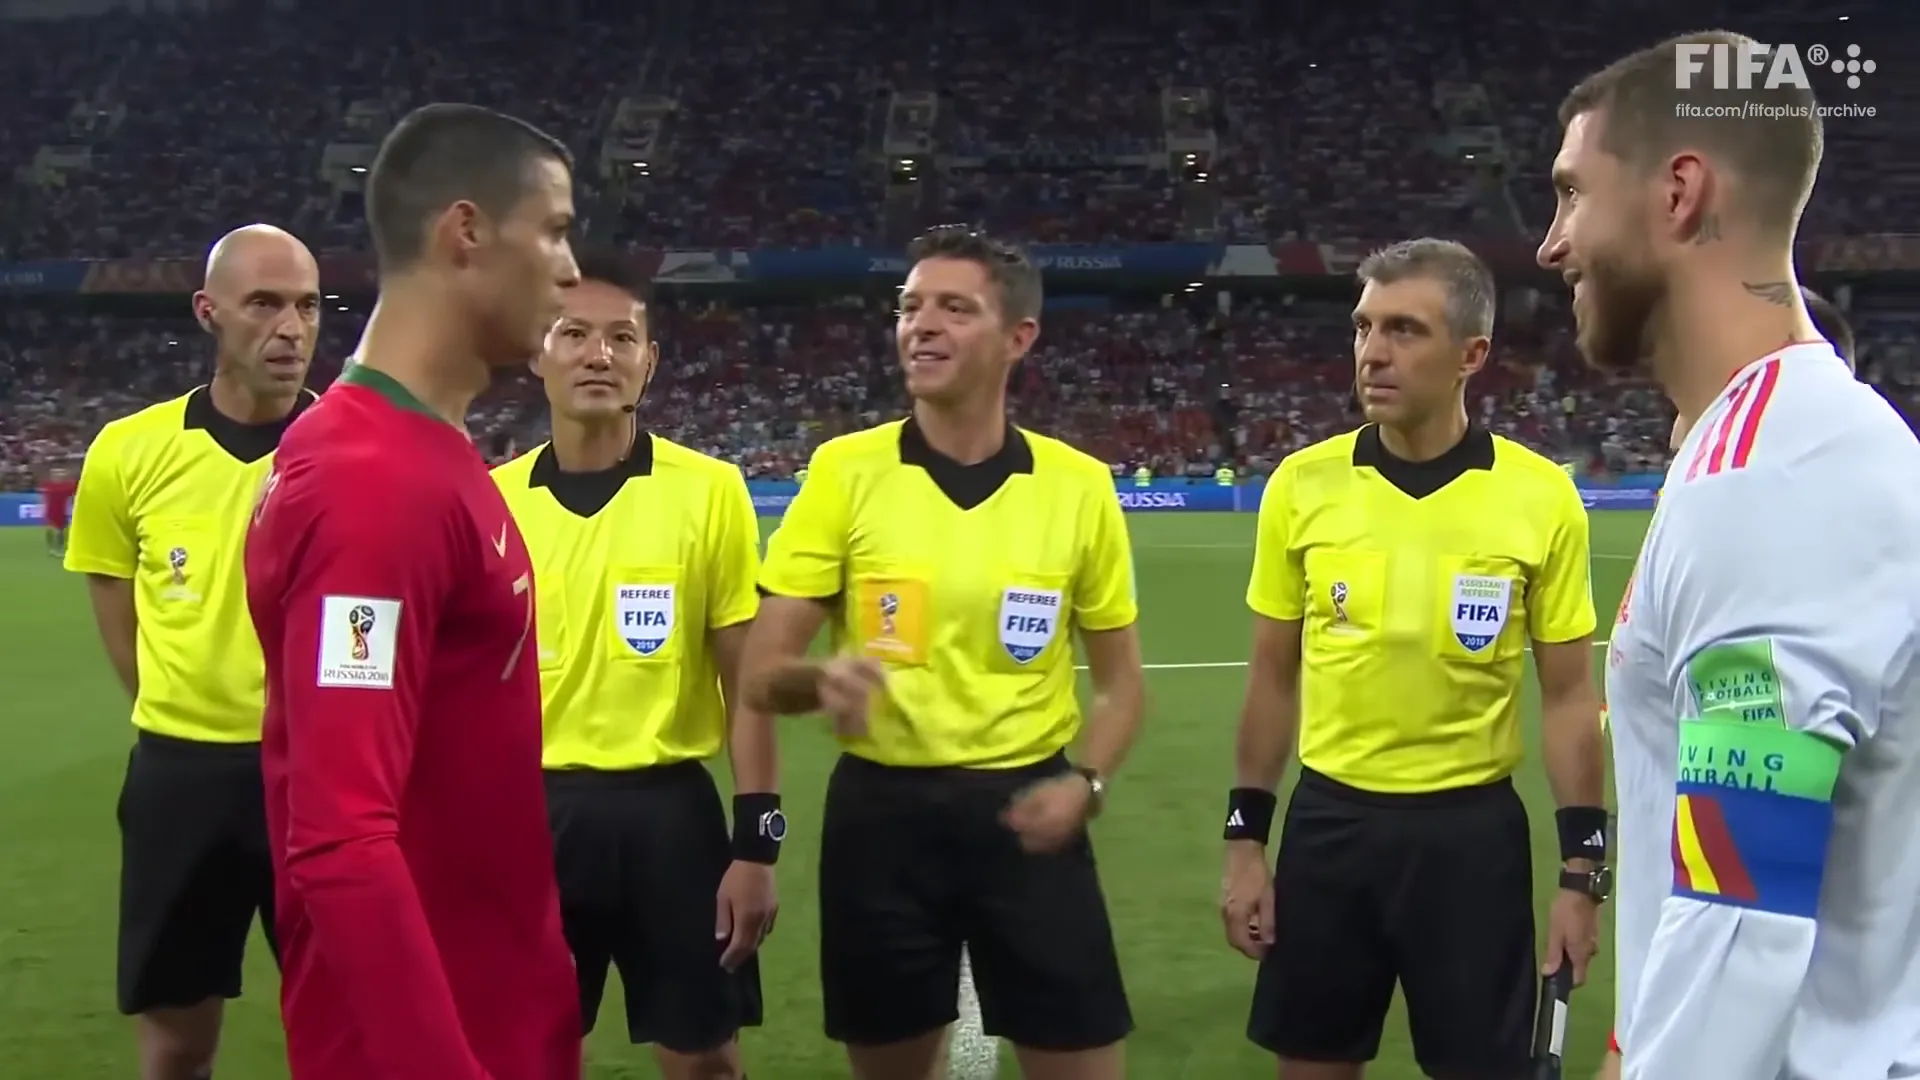
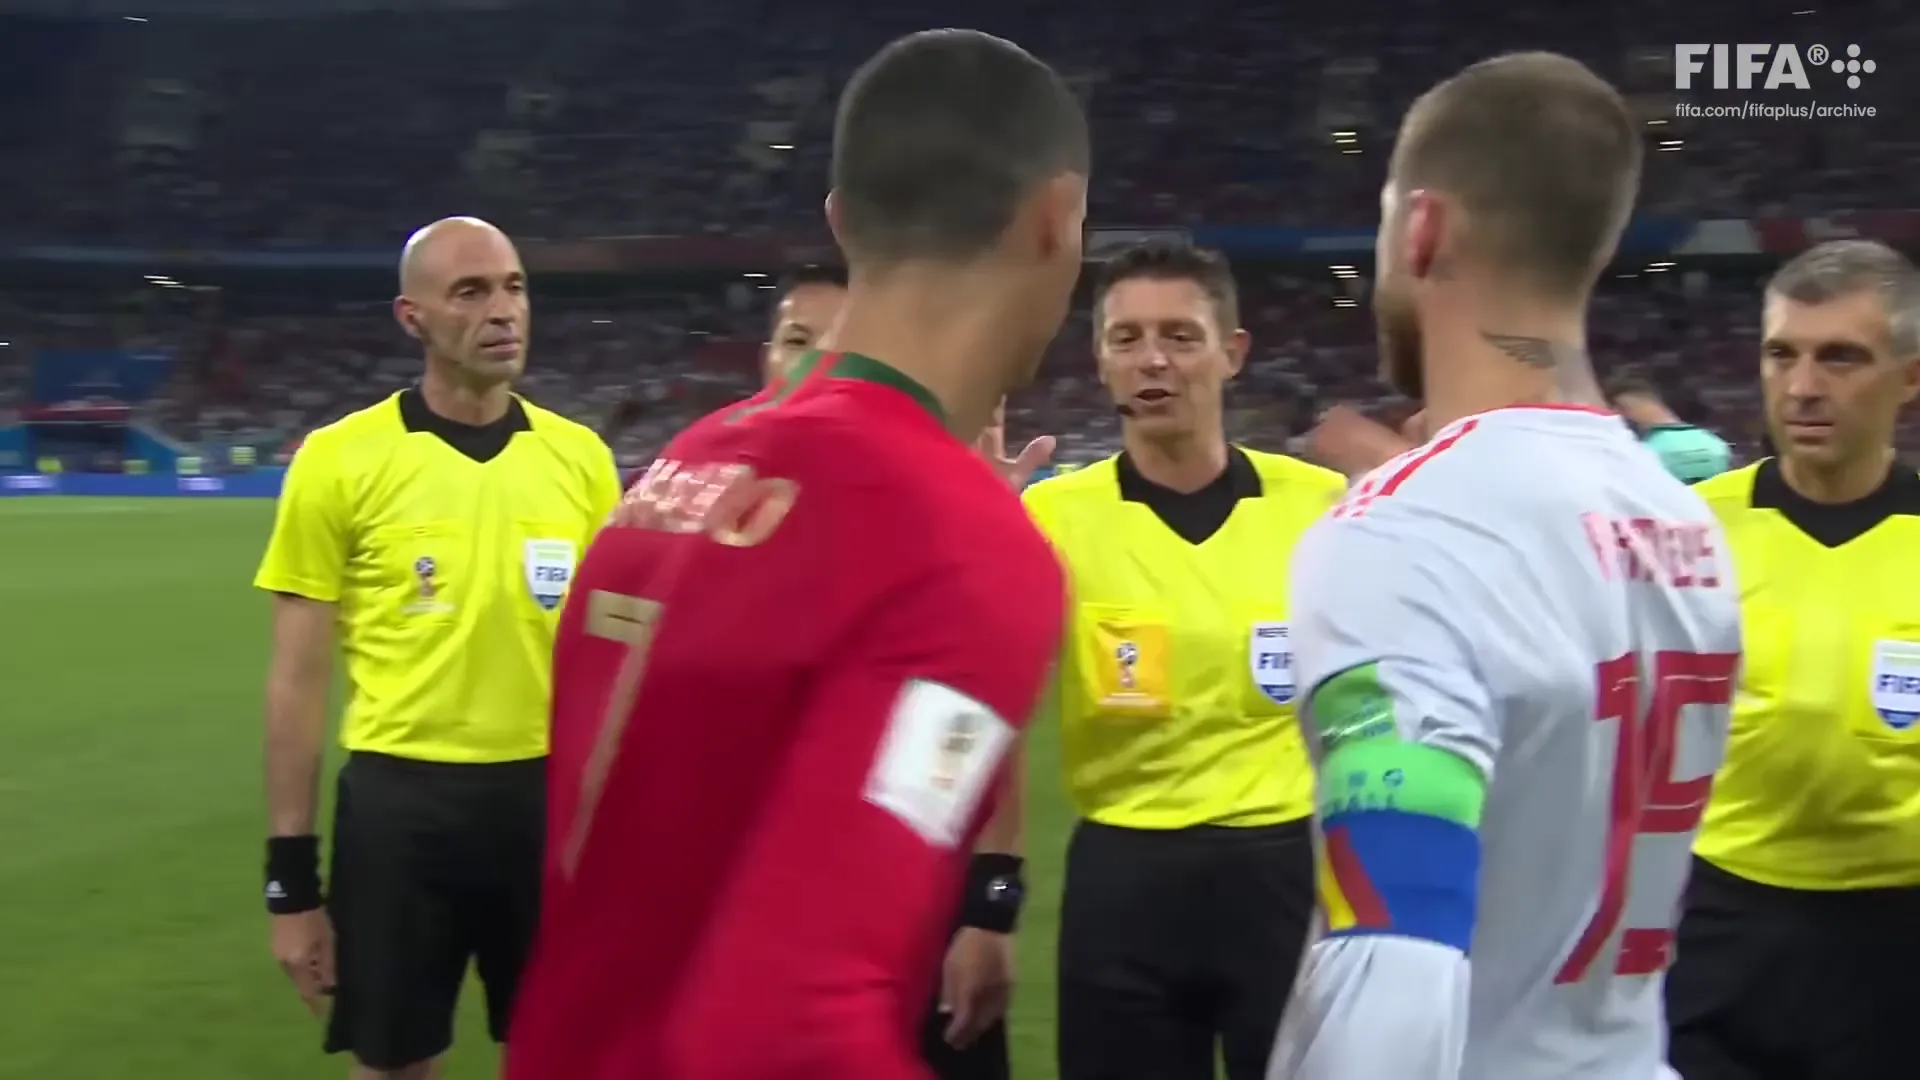
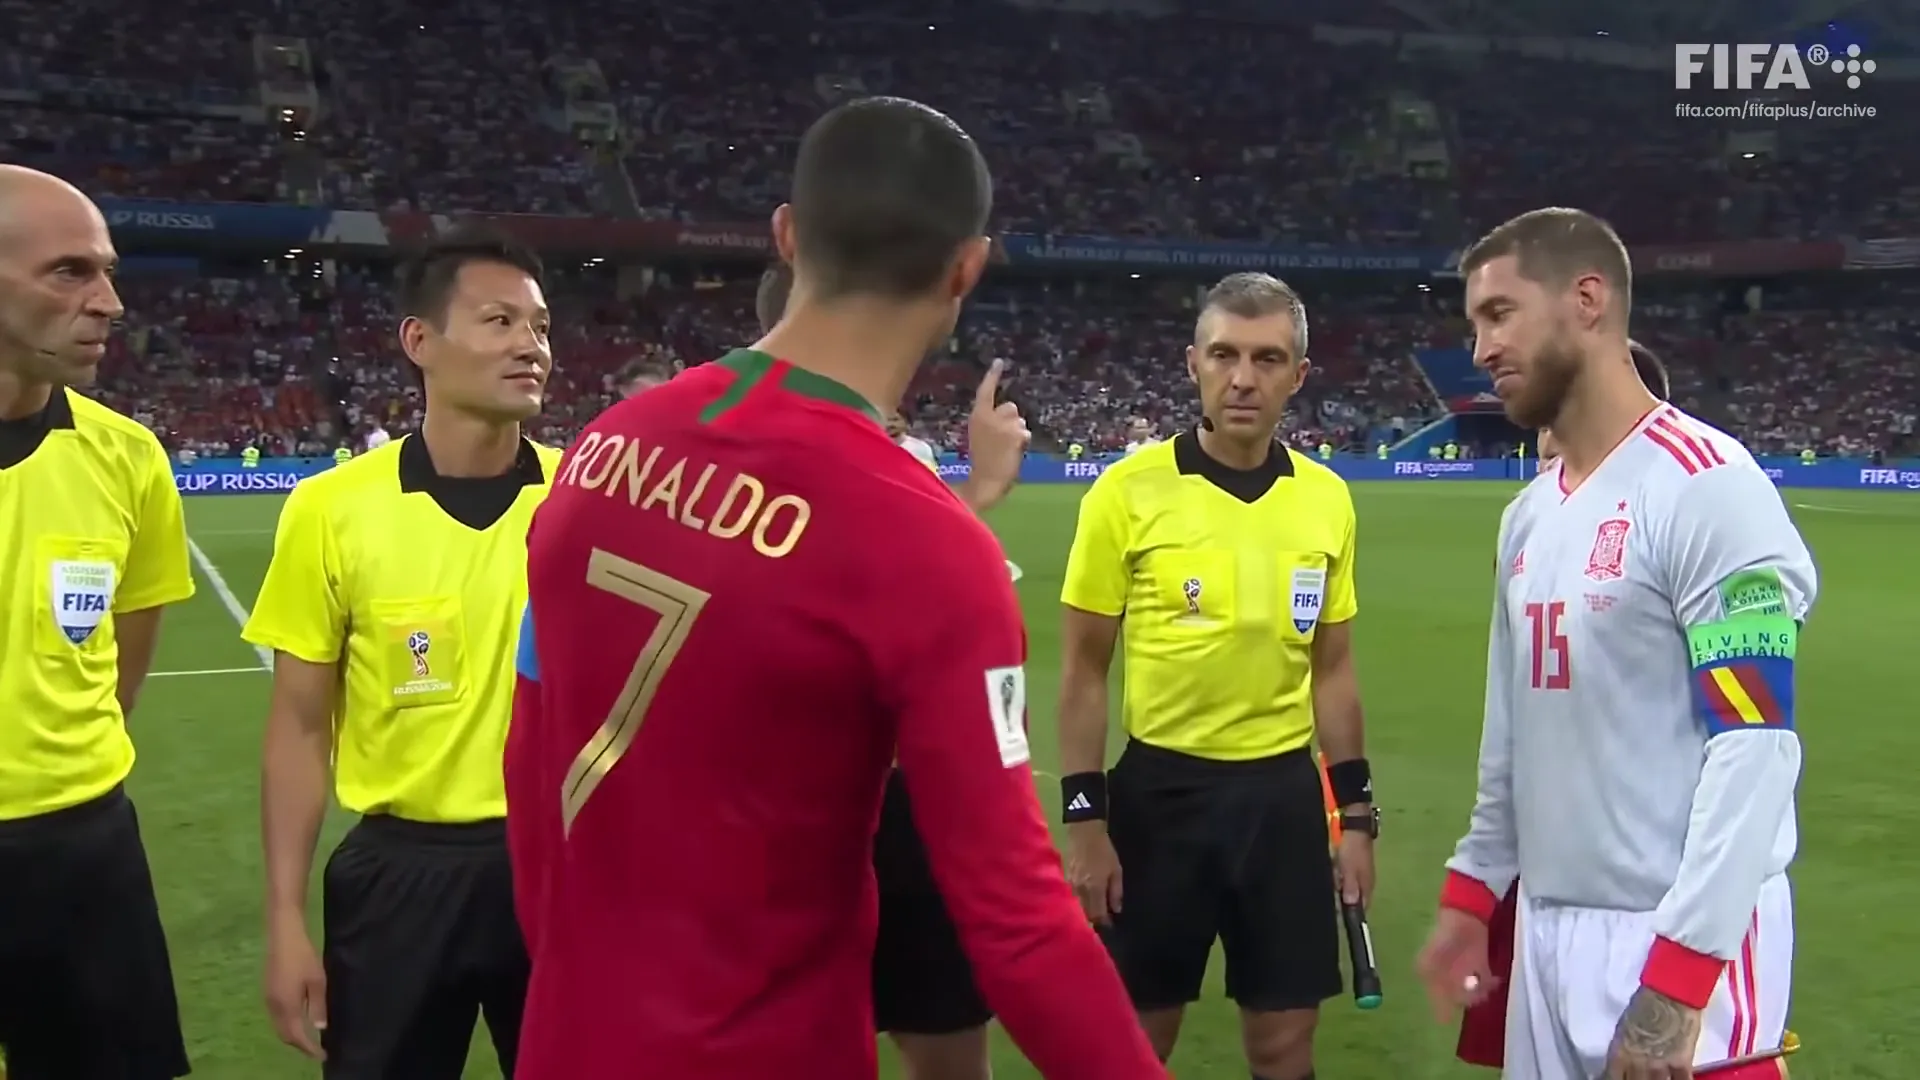

In [42]:
sim = frames.sentence_by_frame.similarity("Cristiano Ronaldo")
(
    frames
    .order_by(sim, asc=False)
    .limit(10)
    .select(frames.sentence_by_frame, frames.frame,similarity=sim)
    .collect()
)

frame,sentence_by_frame
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"

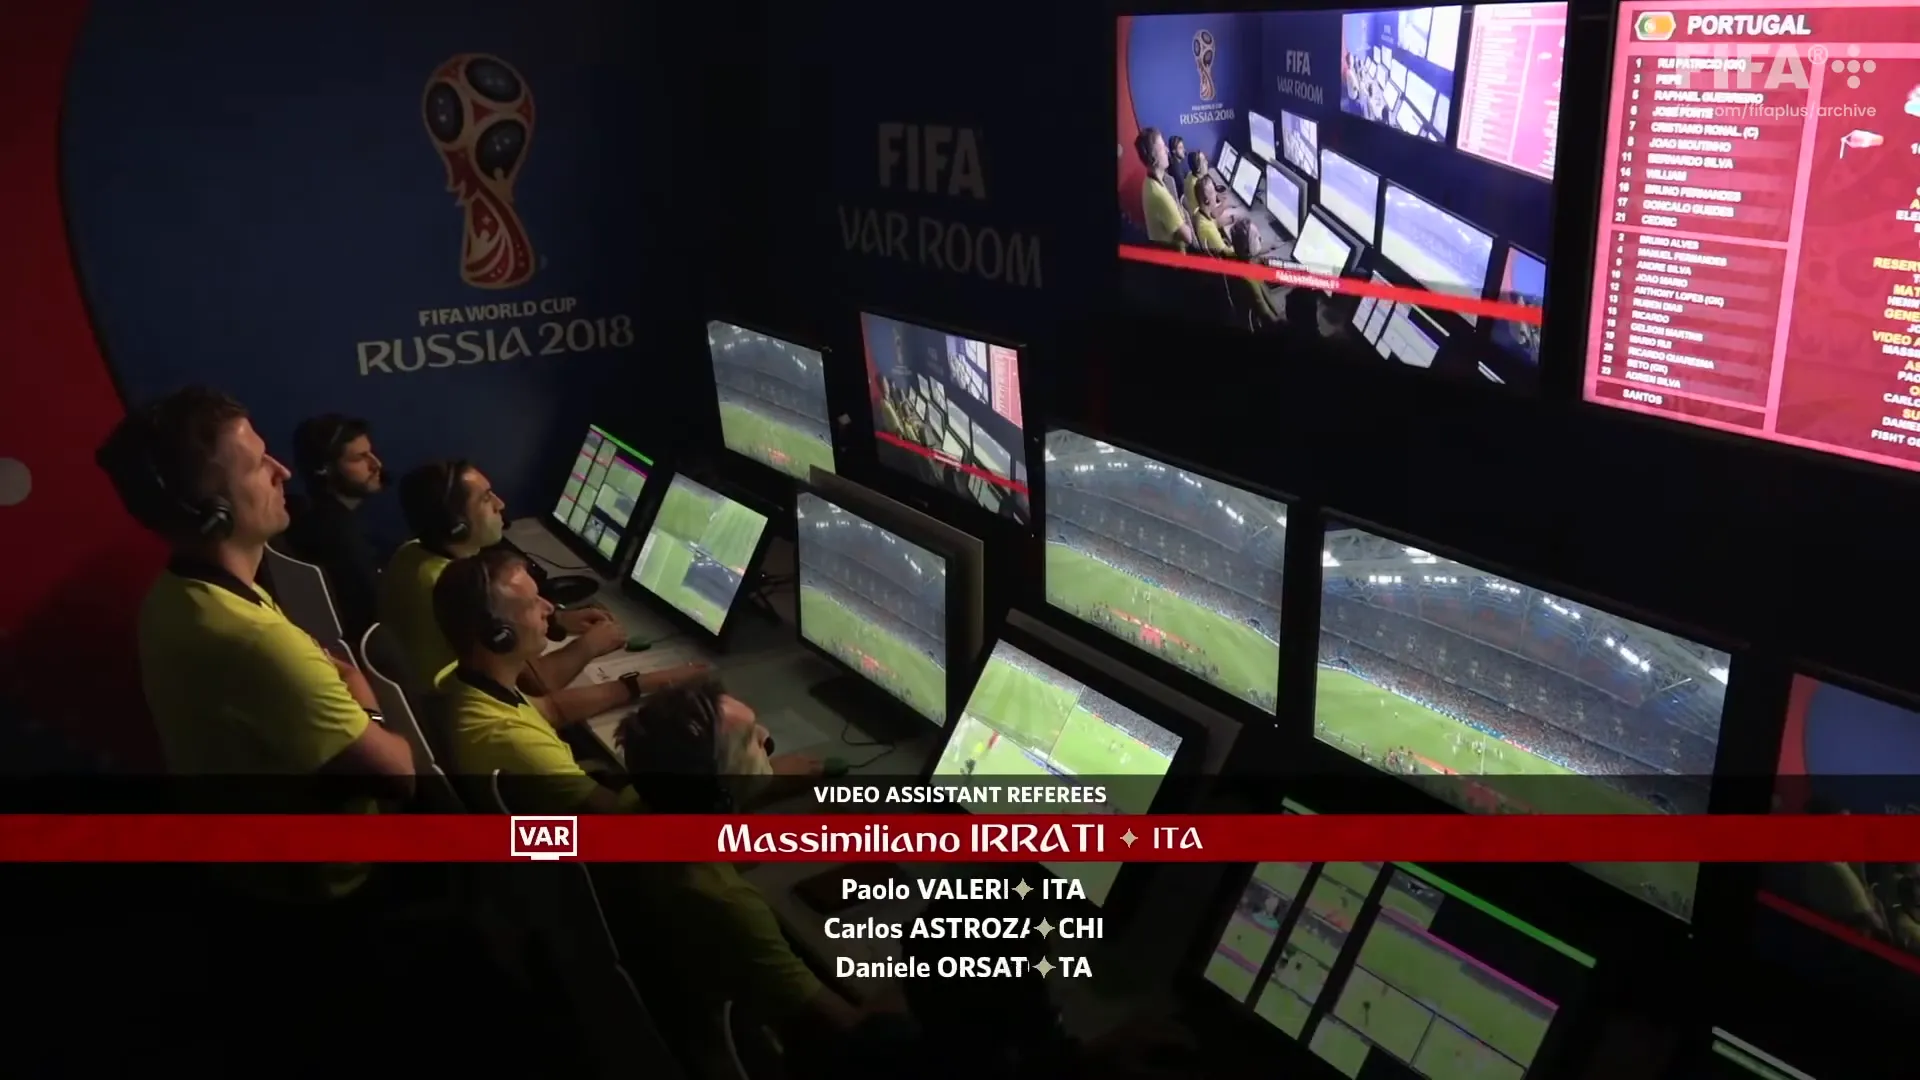
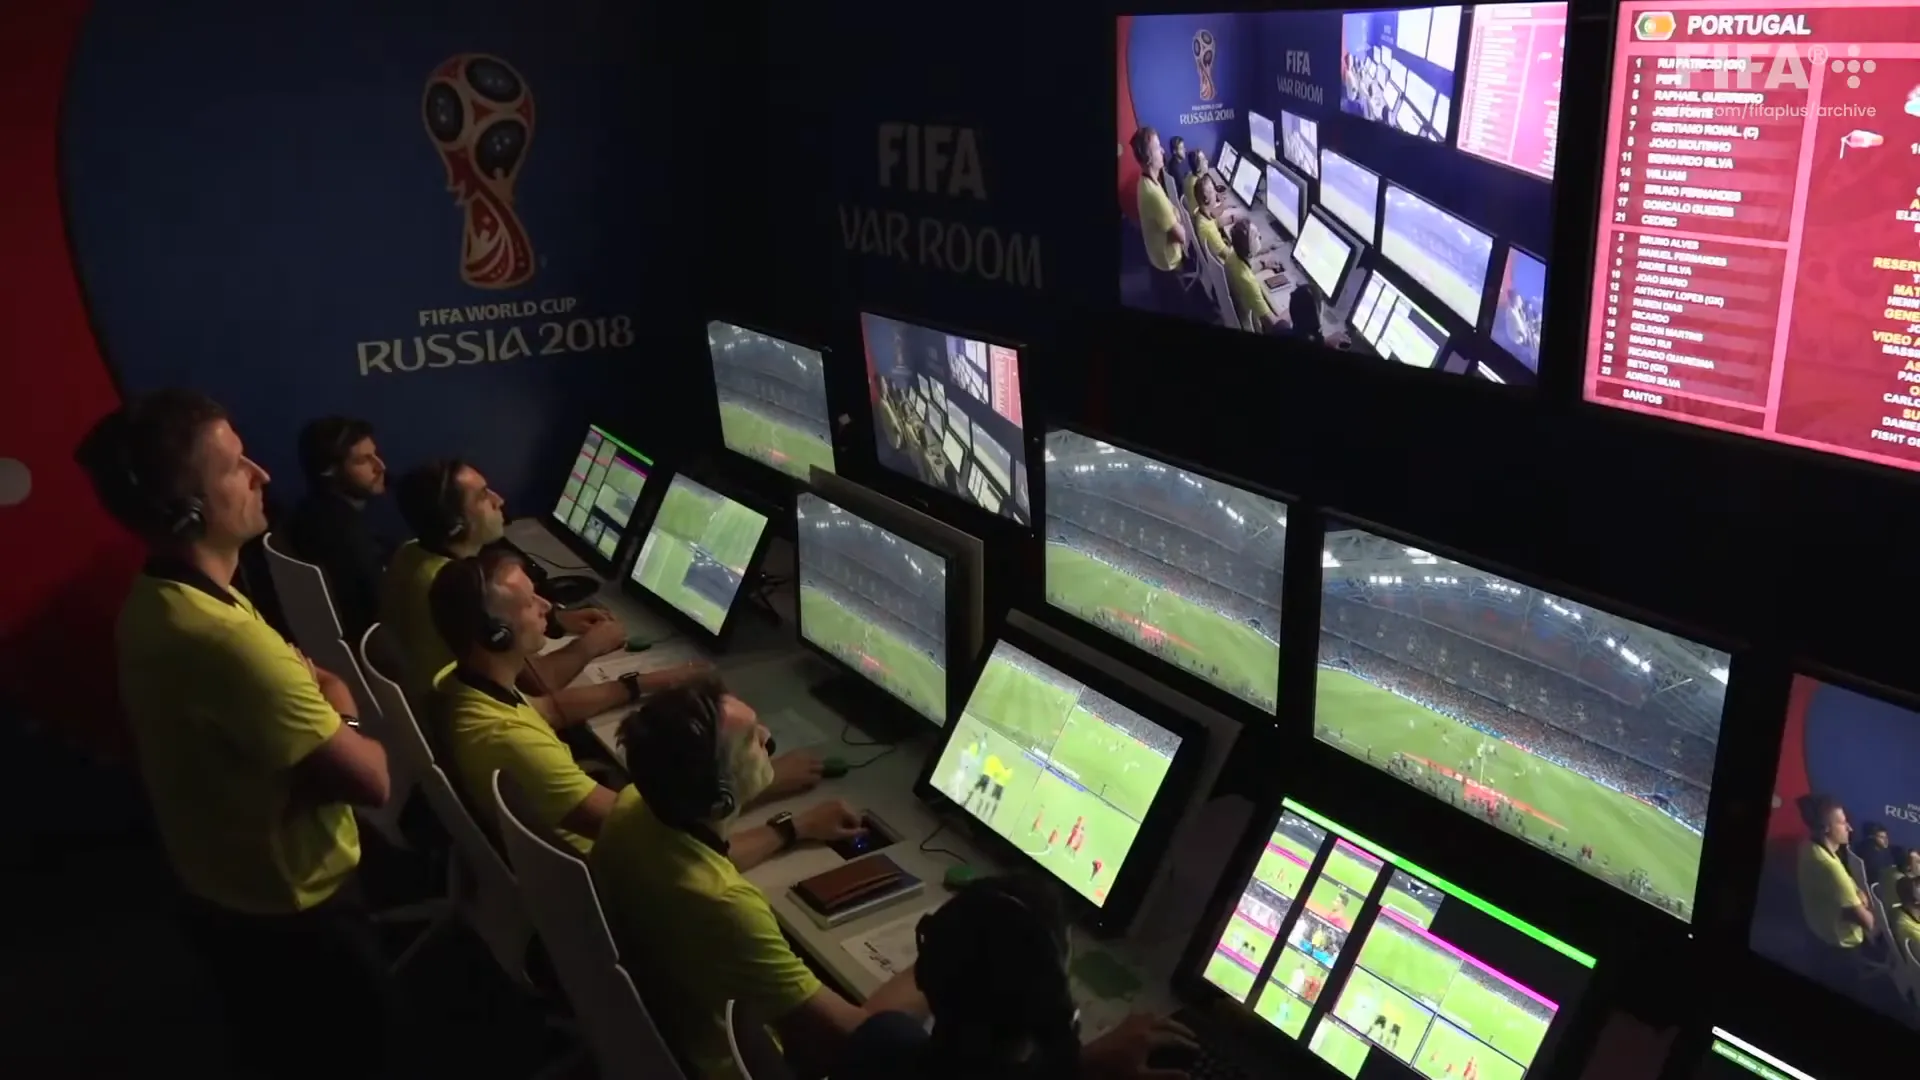
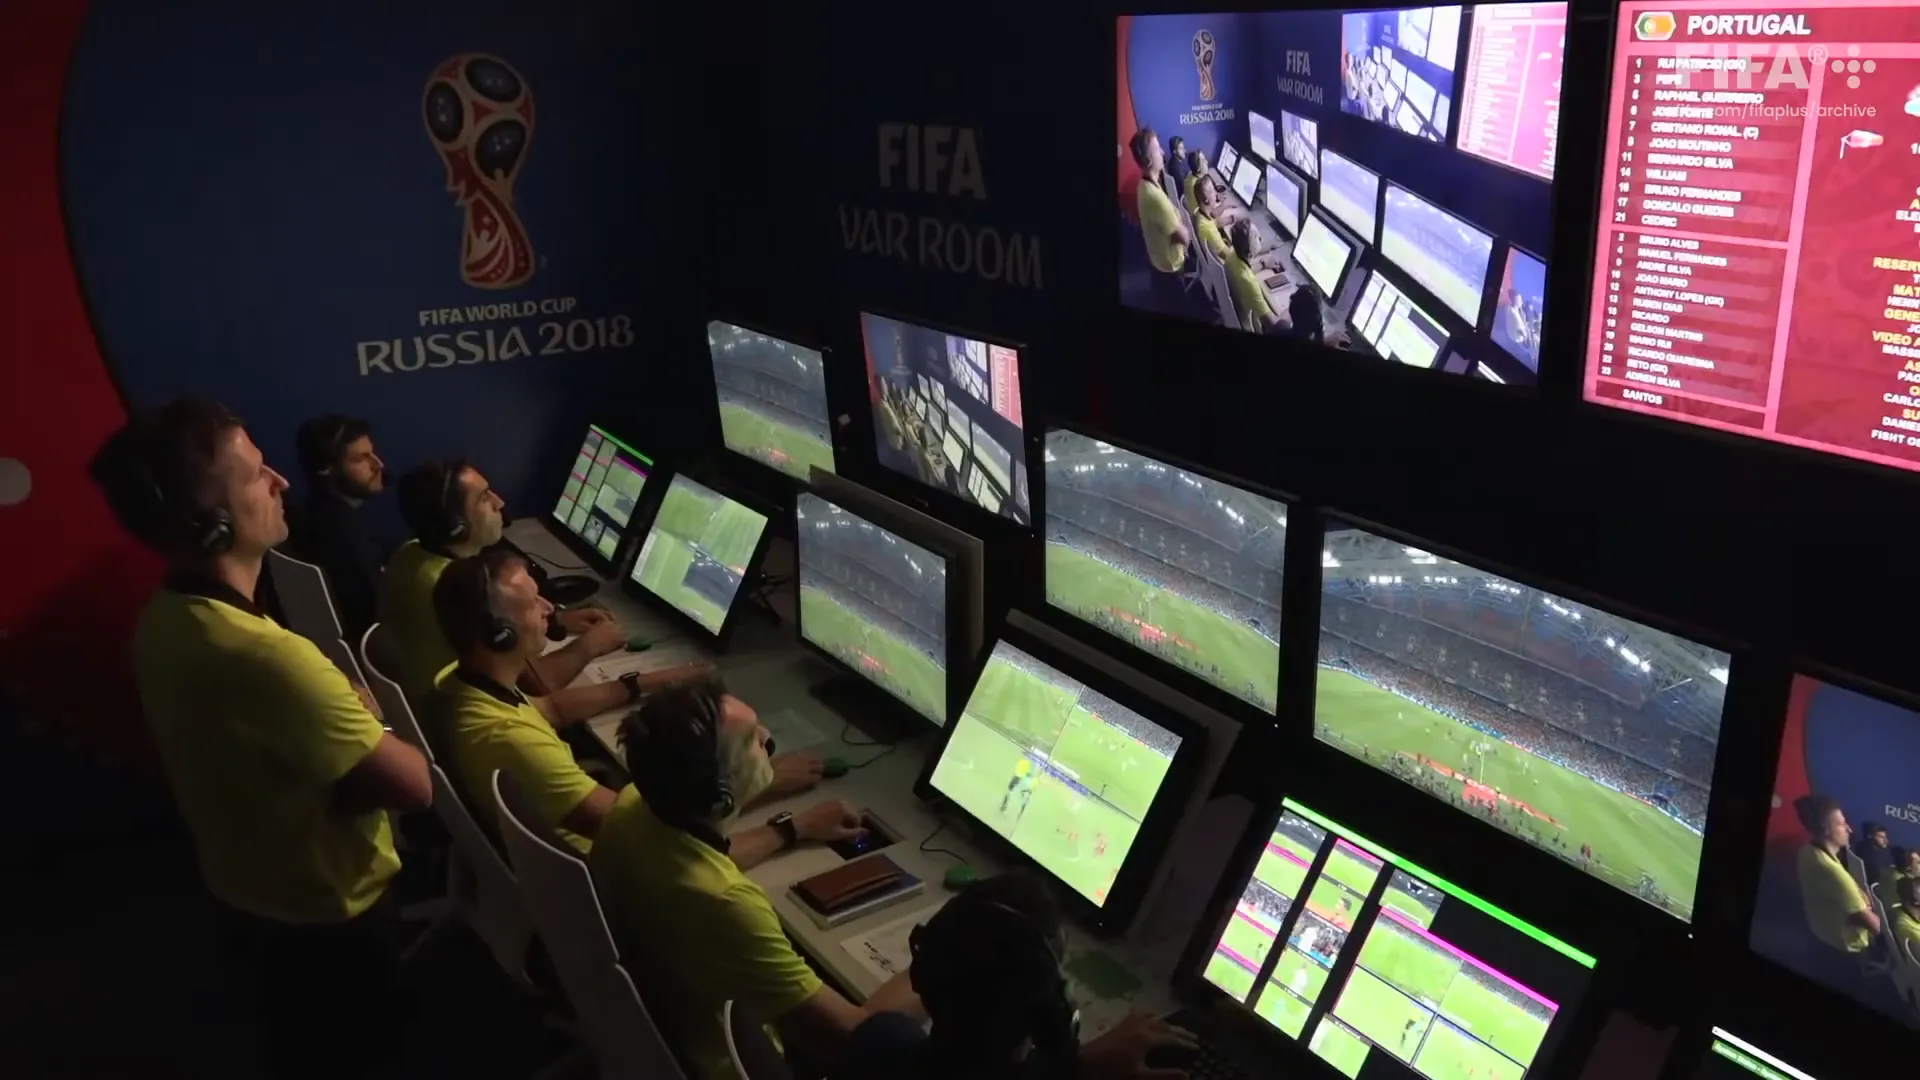
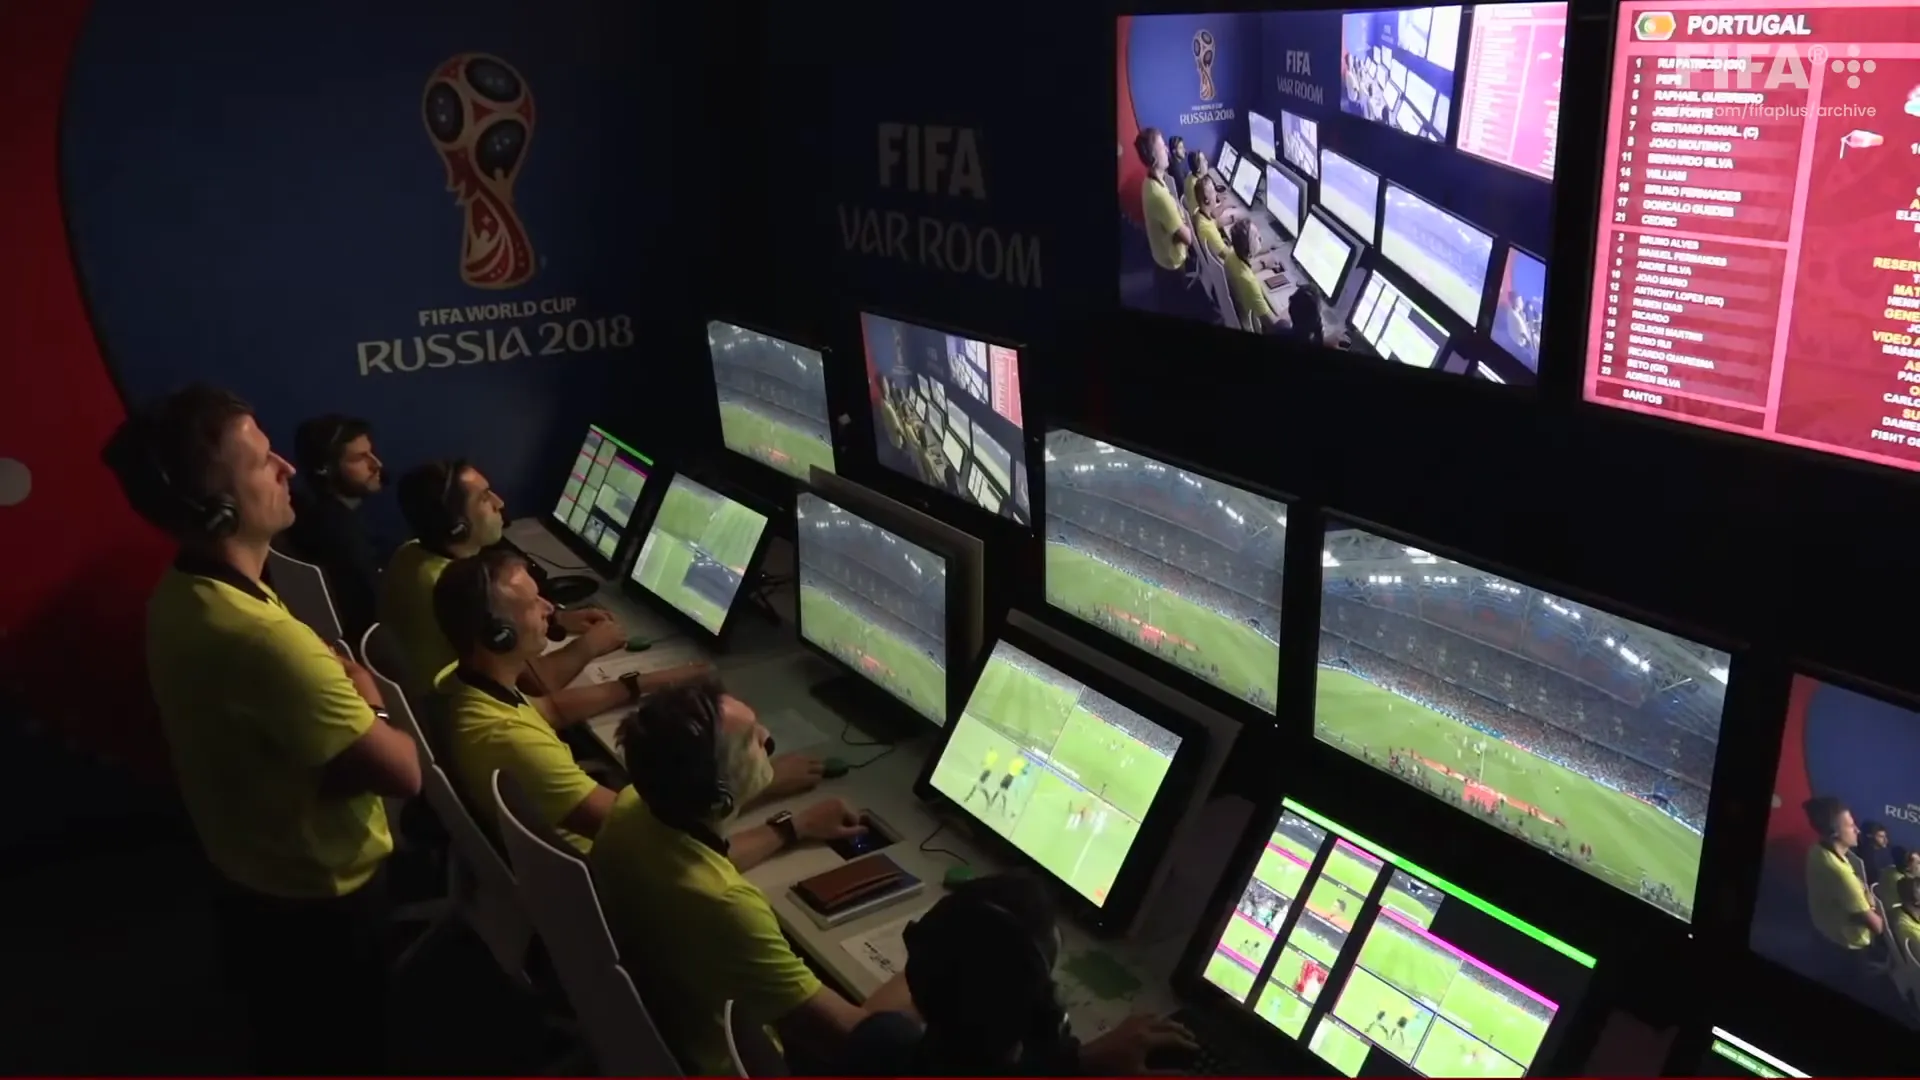
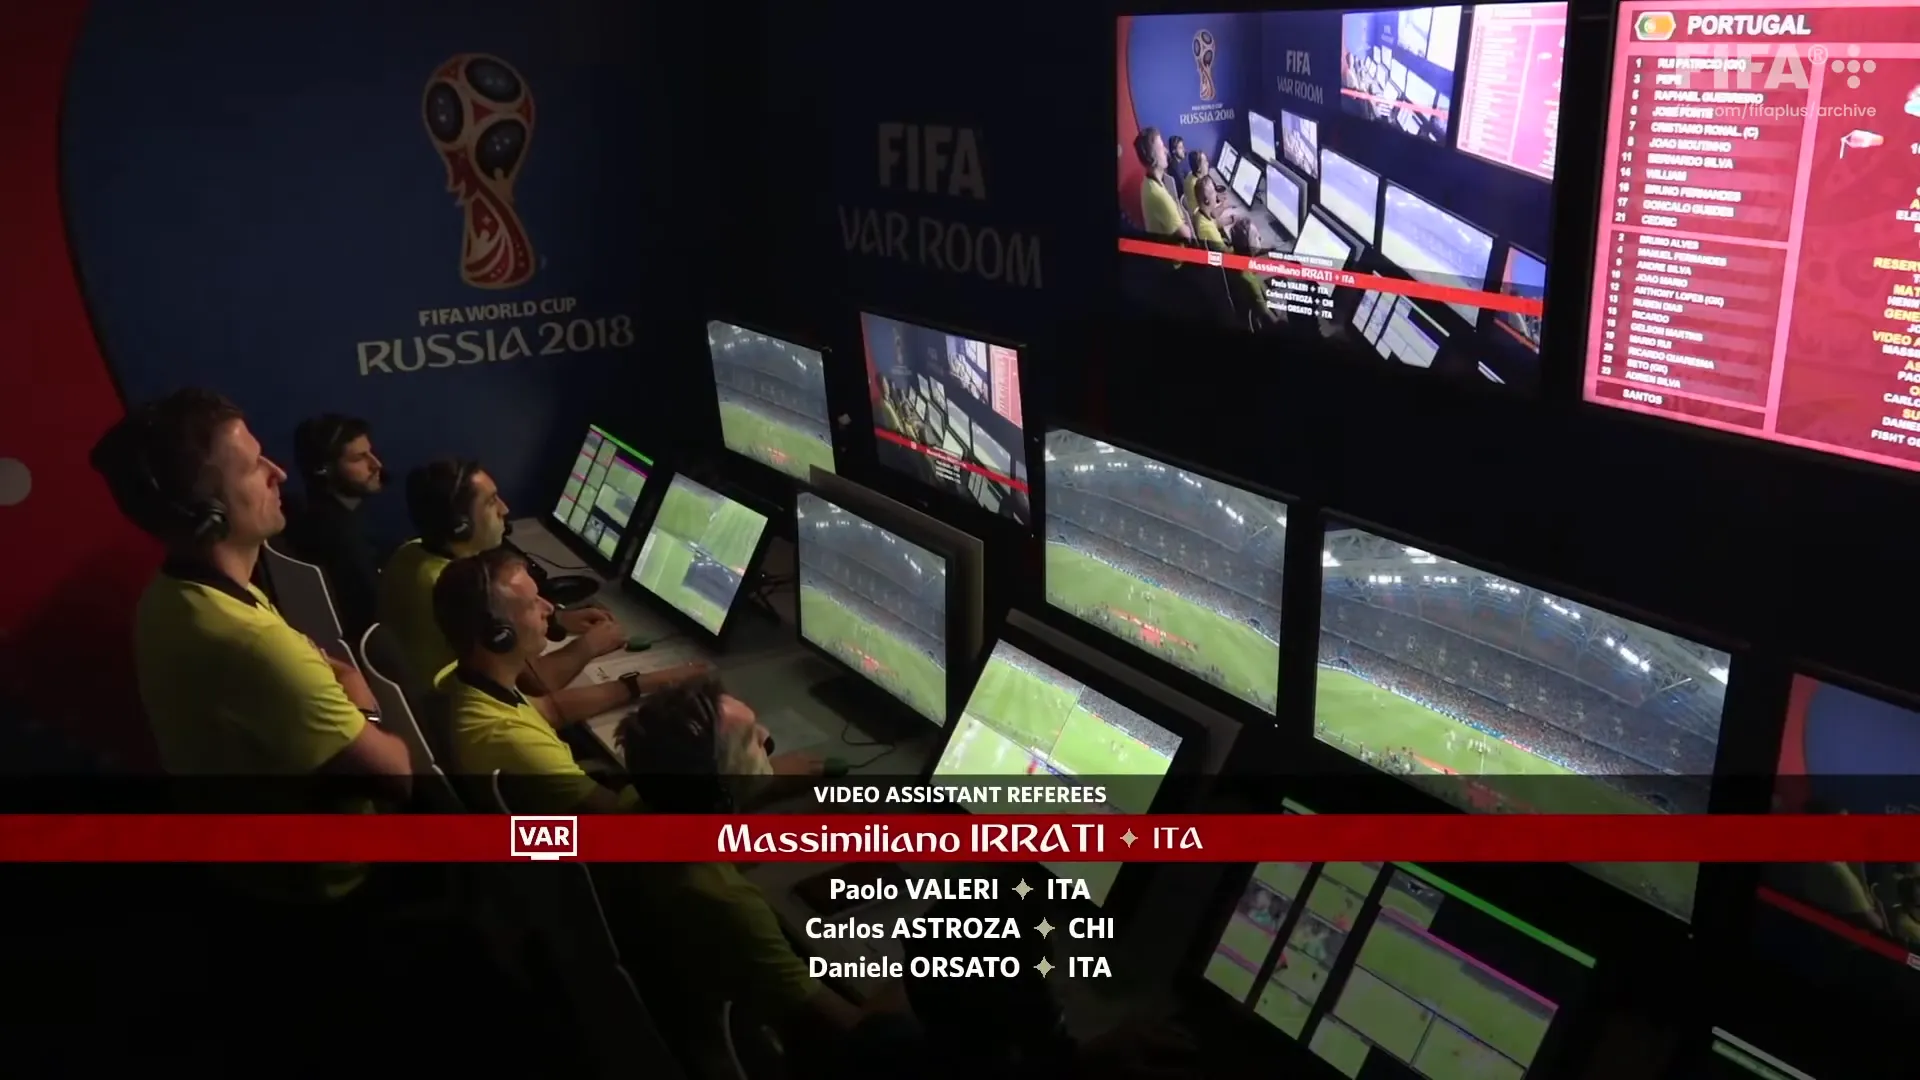

In [37]:
results_text

In [2]:
text_corpus = table.select(
    table.video_caption,
    table.transcription.text
)

@pxt.udf
def compose_semantics(video_caption: pxt.type_system.String, transcript: pxt.type_system.Json) -> str:
    return f"{video_caption}.{transcript['text']}"

In [3]:
text_corpus.show()

video_caption,transcription_text
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game. The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions. The scoreboard indicates that the match is in the 0-0 scoreline, with the time at 0:36.",the red. Portugal in the all red. Spain tonight in the change colours of white with the red trim won by David Silva. It's away by Jose Fonk. Looking for the run up front of Guede. Ronaldo. Little double step over to start
"A soccer match is underway, with the main action being a player attempting to shoot the ball into the goal. The player in a red jersey is in possession of the ball and is dribbling towards the goal, with a player in a white jersey in close proximity, possibly attempting to defend or intercept. The goalkeeper, also in a green jersey, is positioned in front of the goal, ready to react to the play.",before we can take a look at
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game. The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions. The scoreboard indicates that the match is in the 1st minute, with the score at 0-0.","from the 2016 European champions. They've won 79% of their competitive matches under Fernando Santos, just two defeats in 29. That's for Spain, the start of a new era under Fernando Iero. They were unbeaten under Gillian Lopategi."
"A soccer match is underway, with the main action being a player attempting to shoot the ball into the goal. The player in the red jersey is in the process of kicking the ball, which is in mid-air, while the player in the white jersey is running towards the ball, attempting to intercept it. The scoreboard at the top of the image shows the score as 0-0, with the time at 2:08, and the teams are portugal and spain.","I wonder what he's feeling now. The deposed national team coach. She was unveiled as Real Madrid's new coach yesterday. Ronaldo. Is that a penalty it is? Inside the opening three minutes, Cristiano Ronaldo fell in the penalty area and Portugal have the opportunity to take the lead. The challenge coming in."
"A group of soccer players are huddling together on the field, discussing a moment in the game. The players are standing in a circle, with one player in the center, wearing a red jersey with the number 7, who appears to be the focal point of their discussion. The other players are wearing yellow jerseys, indicating they are part of the opposing team.",at eight days ago. Portugal regularly used a 442 formation in qualifying where the gay dash plays just behind Ronaldo or alongside him we will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're forced with their talisman. It's their seventh World Cup in all. Jan-lukaraqui from Italy is in
"The video shows a group of individuals engaged in the action of playing soccer, which involves walking, carrying/holding an object, and watching a person. The players are seated in a control room, surrounded by multiple screens displaying various images and data related to the game, including a live feed of the soccer match and tactical analysis. The screens are arranged in a semi-circle, and the players are wearing yellow shirts, indicating they are part of the same team.","to Italian assistance. Ra'Yuzin Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials, led by Massa Miliano Irati from Italy. David DeHaie was an ever-presenting qualifying. Many of this Spanish team we know."
"The video shows a soccer match between spain and another team, with the players from spain wearing red jerseys with the number 6 on the front, and the opposing team's players wearing white jerseys with the number 1 on the front. The players are standing on a soccer field wit

In [37]:
table.columns

['video',
 'audio',
 'transcription',
 'metadata',
 'video_caption',
 'text',
 'fulltext']

In [4]:
import pixeltable as pxt
from pixeltable.iterators.string import StringSplitter
from pixeltable.functions import huggingface

embed_model = huggingface.sentence_transformer.using(model_id='all-MiniLM-L6-v2')

table.add_computed_column(
    fulltext=compose_semantics(table.video_caption, table.transcription), if_exists="replace"
)

# FIXME: not ok, because each sentecen will be composed with the video description
# and it'll make duplicates when embedding
text_view = pxt.create_view(
    "textdata",
    table,
    iterator=StringSplitter.create(text=table.fulltext, separators='sentence'), if_exists="replace"
)




Added 10 column values with 0 errors.
Inserting rows into `textdata`: 73 rows [00:00, 24812.33 rows/s]
Created view `textdata` with 73 rows, 0 exceptions.


In [8]:
table.select(
    text_view.fulltext
).show(10)

fulltext
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game. The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions. The scoreboard indicates that the match is in the 0-0 scoreline, with the time at 0:36.. the red. Portugal in the all red. Spain tonight in the change colours of white with the red trim won by David Silva. It's away by Jose Fonk. Looking for the run up front of Guede. Ronaldo. Little double step over to start"
"A soccer match is underway, with the main action being a player attempting to shoot the ball into the goal. The player in a red jersey is in possession of the ball and is dribbling towards the goal, with a player in a white jersey in close proximity, possibly attempting to defend or intercept. The goalkeeper, also in a green jersey, is positioned in front of the goal, ready to react to the play.. before we can take a look at"
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game. The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions. The scoreboard indicates that the match is in the 1st minute, with the score at 0-0.. from the 2016 European champions. They've won 79% of their competitive matches under Fernando Santos, just two defeats in 29. That's for Spain, the start of a new era under Fernando Iero. They were unbeaten under Gillian Lopategi."
"A soccer match is underway, with the main action being a player attempting to shoot the ball into the goal. The player in the red jersey is in the process of kicking the ball, which is in mid-air, while the player in the white jersey is running towards the ball, attempting to intercept it. The scoreboard at the top of the image shows the score as 0-0, with the time at 2:08, and the teams are portugal and spain.. I wonder what he's feeling now. The deposed national team coach. She was unveiled as Real Madrid's new coach yesterday. Ronaldo. Is that a penalty it is? Inside the opening three minutes, Cristiano Ronaldo fell in the penalty area and Portugal have the opportunity to take the lead. The challenge coming in."
"A group of soccer players are huddling together on the field, discussing a moment in the game. The players are standing in a circle, with one player in the center, wearing a red jersey with the number 7, who appears to be the focal point of their discussion. The other players are wearing yellow jerseys, indicating they are part of the opposing team.. at eight days ago. Portugal regularly used a 442 formation in qualifying where the gay dash plays just behind Ronaldo or alongside him we will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're forced with their talisman. It's their seventh World Cup in all. Jan-lukaraqui from Italy is in"
"The video shows a group of individuals engaged in the action of playing soccer, which involves walking, carrying/holding an object, and watching a person. The players are seated in a control room, surrounded by multiple screens displaying various images and data related to the game, including a live feed of the soccer match and tactical analysis. The screens are arranged in a semi-circle, and the players are wearing yellow shirts, indicating they are part of the same team.. to Italian assistance. Ra'Yuzin Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials, led by Massa Miliano Irati from Italy. David DeHaie was an ever-presenting qualifying. Many of this Spanish team we know."
"The video shows a soccer match between spain and another team, with the players from spain wearing red jerseys with the number 6 on the front, and the opposing team's players wearing white jerseys with the number 1 on the front. The players are standing on a soccer field with a green surface and wh

In [9]:
print(table)
table.select(
    table.video,
    table.fulltext
).show(3)

Table
'poc.data'

    Column Name    Type                                      Computed With
          video   Video                                                   
          audio   Audio                 extract_audio(video, format='mp3')
  transcription    Json           transcribe(audio=audio, model='base.en')
       metadata    Json                                get_metadata(audio)
  video_caption  String  core.functions.caption_video(video=video, prom...
           text  String    compose_semantics(video_caption, transcription)
       fulltext  String    compose_semantics(video_caption, transcription)


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/video_chunks_ffmpeg_sub_p_zkqqqx/chunk_006.mp4'

                                               video  \
0  /tmp/video_chunks_ffmpeg_sub_p_zkqqqx/chunk_00...   
1  /tmp/video_chunks_ffmpeg_sub_p_zkqqqx/chunk_00...   
2  /tmp/video_chunks_ffmpeg_sub_p_zkqqqx/chunk_00...   

                                            fulltext  
0  A soccer match is underway, with players from ...  
1  A soccer match is underway, with the main acti...  
2  A soccer match is underway, with players from ...  

In [48]:
texts = table.select(
    table.fulltext
).collect().to_pandas()

In [54]:
texts.to_csv("texts_csv.csv")

In [29]:
from pixeltable.iterators.string import StringSplitter
from pixeltable.functions.huggingface import sentence_transformer

embd_func = sentence_transformer.using(model_id='sentence-transformers/all-MiniLM-L12-v2')
sentences_view = pxt.create_view(
    "sentences",
    table,
    iterator=StringSplitter.create(text=table.fulltext, separators='sentence'),
    if_exists='replace'
)
sentences_view.select(
    sentences_view.text,
    sentences_view.pos
).show(3)


Inserting rows into `sentences`: 73 rows [00:00, 31558.87 rows/s]
Created view `sentences` with 73 rows, 0 exceptions.


text,pos
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game.",0
"The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions.",1
"The scoreboard indicates that the match is in the 0-0 scoreline, with the time at 0:36.. the red.",2


In [30]:
from pixeltable.functions.huggingface import sentence_transformer

sentences_view.add_embedding_index(
    'text',
    embedding=sentence_transformer.using(model_id='intfloat/e5-large-v2')
)

Error: The function `None` is not a valid embedding: it must return a 1-dimensional array of a specific length, but returns Array[(None,), Float]

In [24]:
import numpy as np
import pgvector
from pixeltable.functions.huggingface import clip, sentence_transformer

embed_model = sentence_transformer.using(
    model_id="intfloat/e5-large-v2"
)

@pxt.udf
def embed_string(s: pxt.type_system.String):
    embeddings = embed_model(s)
    return embeddings

# @pxt.expr_udf
# def str_embed(s: str):
#     return sentence_transformer.using(s, model_id='all-mpnet-base-v2')



table.add_computed_column(
    embedding=embed_string(table.fulltext)
)


Error: Cannot infer pixeltable return type

In [ ]:
@pxt.query
def get_relevant_context(query_text: str, limit: int = 3):
    sim = text_view.text.similarity(query_text)
    # Return a list of strings (text of relevant chunks)
    return text_view.order_by(sim, asc=False).limit(limit).select(text_view.text)